Author: Justus Heilingbrunner
***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import math
import random
import os
import requests
import dotenv
import re
import time
import torch

import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.options.display.max_columns = None

torch.set_default_dtype(torch.float)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.set_num_threads(1)

RANDOM_SEED = 123
os.environ["PL_GLOBAL_SEED"] = str(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

***
***
# The Data



## Hub List all time + pick up and drop offs.csv

In [3]:
df = pd.read_csv('Data/Hub List all time + pick up and drop offs.csv')
df.head()

,id,name,state,created_at,maximum_capacity,pickups,dropoffs
0,30467,Stadtwerke Pop-Up,public,2024-09-12 12:45:29.843902,0,4,1
1,30466,Mobilitätsfest Pop-up,public,2024-09-12 12:07:04.481416,0,15,16
2,30464,Pop Up Rathaus event,public,2024-09-12 07:25:05.597799,20,7,3
3,30434,Felde Gemeindezentrum,public,2024-09-08 09:01:16.289455,18,7,9
4,30420,IPN Pop Up,disabled,2024-09-05 20:53:56.364054,10,0,0


In [4]:
df.head(233)

,id,name,state,created_at,maximum_capacity,pickups,dropoffs
0,30467,Stadtwerke Pop-Up,public,2024-09-12 12:45:29.843902,0,4,1
1,30466,Mobilitätsfest Pop-up,public,2024-09-12 12:07:04.481416,0,15,16
2,30464,Pop Up Rathaus event,public,2024-09-12 07:25:05.597799,20,7,3
3,30434,Felde Gemeindezentrum,public,2024-09-08 09:01:16.289455,18,7,9
4,30420,IPN Pop Up,disabled,2024-09-05 20:53:56.364054,10,0,0
...,...,...,...,...,...,...,...
228,24371,Anleger Reventlou,public,2022-12-19 13:18:10.719836,50,30232,30138
229,24370,Alter Markt,public,2022-12-19 13:18:10.313777,25,15439,15676
230,24369,Alte Mu/Brunswiker Str.,public,2022-12-19 13:18:09.902522,15,7544,7593
231,24368,Umsteiger,public,2022-12-19 13:18:09.467309,20,7633,7629


In [5]:
df['name'].nunique(), df['id'].nunique()

(233, 233)

In [6]:
df['name'].unique()

array(['Stadtwerke Pop-Up', 'Mobilitätsfest Pop-up',
       'Pop Up Rathaus event', 'Felde Gemeindezentrum', 'IPN Pop Up ',
       'SH Netz Cup Pop Up', 'Wankendorf Zob', 'Sporthalle Saxtorfer Weg',
       'Osterby Veranstaltung Pop Up ', 'Hohes Arsenal', 'Jungmannufer',
       'Eiche Dänischenhagen', 'Bushaltestelle Eiderbrücke',
       'Herzog-Friedrich-Straße (ZOB)', 'Rondeel', 'VHS Kurs ',
       'TÖZ Eckernförde ', 'Martinshaus', 'Pop-up Barsbek Korntage',
       'Pop Up VeloCenter ', 'REWE Klausdorf', 'Ostseepark',
       'Stadtwerke / Bürgerhaus Klausdorf', 'Bahnhof Raisdorf',
       'Freibad Raisdorf (saisonal bis 22.09.24)',
       'Rathaus Schwentinental', 'Pop-up Seewiese Bünsdorf',
       'Eiderbad Saison-Station', 'Kiwo Sparkassen Service',
       'B502 Schönkirchener Straße ', 'Langer Rehm P+R',
       'Langer Rehm (Rewe)', 'Wörthstraße', 'KiWo Willestraße ',
       'ab 12 Uhr - KiWo Nordeingang', 'ab 12 Uhr - KiWo Südeingang',
       'KiWo Nordmarksportfeld', 'KiWo Prinz

In [7]:
df['id'].unique()

array([30467, 30466, 30464, 30434, 30420, 30390, 30282, 30207, 30185,
       30156, 30155, 30151, 30147, 30146, 30145, 30126, 30121, 30120,
       30095, 30084, 30027, 30026, 30025, 30024, 30023, 30022, 30011,
       29982, 29974, 29965, 29964, 29963, 29946, 29942, 29941, 29940,
       29939, 29938, 29937, 29936, 29935, 29934, 29933, 29745, 29663,
       29347, 29346, 29345, 29253, 29224, 29200, 29198, 29147, 29112,
       29109, 29083, 29049, 28932, 28814, 28813, 28812, 28811, 28804,
       28803, 28802, 28801, 28800, 28799, 28798, 28797, 28796, 28795,
       28794, 28793, 28792, 28791, 28790, 28789, 28749, 28738, 28264,
       27717, 27567, 27452, 27451, 27450, 27449, 27448, 27447, 27446,
       27445, 27444, 27443, 27442, 27441, 27440, 27382, 27381, 27380,
       27379, 27378, 27377, 27376, 27375, 27374, 27373, 27372, 27209,
       27183, 26889, 26805, 26730, 26725, 26724, 26708, 26653, 26224,
       26209, 24602, 24482, 24481, 24479, 24478, 24477, 24476, 24475,
       24474, 24473,

**Hub List all time + pick up and drop offs.csv | Features:**

1. **id**: 
2. **name**: 
3. **state**: 
4. **created_at**: 
5. **maximum_capacity**: 
6. **pickups**: 
7. **dropoffs**: 

In [8]:
print('number of missing values:', df.isnull().sum().sum())
print('number of NaN values:', df.isna().sum().sum())
df.info()

number of missing values: 0
number of NaN values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                233 non-null    int64 
 1   name              233 non-null    object
 2   state             233 non-null    object
 3   created_at        233 non-null    object
 4   maximum_capacity  233 non-null    int64 
 5   pickups           233 non-null    int64 
 6   dropoffs          233 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 12.9+ KB


In [9]:
# look at dataset
print('Shape:', df.shape)
print('Columns:', df.columns)
print('\ndifferent names:', df['name'].nunique())
print('unique states:', df['state'].nunique())
print(df['state'].unique())
print('\nmaximal capacity:', df['maximum_capacity'].max())
print('minimal capacity:', df['maximum_capacity'].min())
print(df['maximum_capacity'].unique())
print('\n')
print(df['maximum_capacity'].value_counts()[:5])

Shape: (233, 7)
Columns: Index(['id', 'name', 'state', 'created_at', 'maximum_capacity', 'pickups',
       'dropoffs'],
      dtype='object')

different names: 233
unique states: 3
['public' 'disabled' 'fellows']

maximal capacity: 150
minimal capacity: 0
[  0  20  18  10   7  15  16  12  50   6  30  25 150  19  14  40  21  80
  35]


maximum_capacity
15    78
20    58
30    28
0     23
25    20
Name: count, dtype: int64


## 2024 - Hub ID & Drop Off - Pick Up numbers.csv

In [10]:
df_time = pd.read_csv('Data/2024 - Hub ID & Drop Off - Pick Up numbers.csv', sep=';')
df_time.head()

,hub_id,Days in full_date,Average bike_count,# of unique dropoff_hub_id,# of unique pickup_hub_id
0,2180.0,01/01/2024,6.282412,NaN,NaN
1,2180.0,02/01/2024,6.080100,NaN,NaN
2,2180.0,04/01/2024,6.078173,NaN,NaN
3,2180.0,05/01/2024,5.936238,NaN,NaN
4,2180.0,07/01/2024,6.443539,NaN,NaN


**2024 - Hub ID & Drop Off - Pick Up numbers.csv | Features:**

1. **hub_id**: 
2. **days in full_date**: 
3. **Average bike_count**: 
4. **# of unique dropoff_hub_id**: 
5. **# of unique pcikup_hub_id**: 

In [11]:
print('number of missing values:', df_time.isnull().sum().sum())
print('number of NaN values:', df_time.isna().sum().sum())
df_time.info()

number of missing values: 446
number of NaN values: 446
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6930 entries, 0 to 6929
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hub_id                      6930 non-null   float64
 1   Days in full_date           6930 non-null   object 
 2   Average bike_count          6930 non-null   float64
 3   # of unique dropoff_hub_id  6707 non-null   float64
 4   # of unique pickup_hub_id   6707 non-null   float64
dtypes: float64(4), object(1)
memory usage: 270.8+ KB


In [12]:
# look at dataset
print('Shape:', df_time.shape)
print('Columns:', df_time.columns)

Shape: (6930, 5)
Columns: Index(['hub_id', 'Days in full_date', 'Average bike_count',
       '# of unique dropoff_hub_id', '# of unique pickup_hub_id'],
      dtype='object')


***

## Grafiken

In [18]:
df_time

,hub_id,Days in full_date,Average bike_count,# of unique dropoff_hub_id,# of unique pickup_hub_id
0,2180.0,2024-01-01,6.282412,NaN,NaN
1,2180.0,2024-01-02,6.080100,NaN,NaN
2,2180.0,2024-01-04,6.078173,NaN,NaN
3,2180.0,2024-01-05,5.936238,NaN,NaN
4,2180.0,2024-01-07,6.443539,NaN,NaN
...,...,...,...,...,...
6925,26889.0,2024-09-14,6.150918,21.0,20.0
6926,26889.0,2024-09-15,6.229018,12.0,12.0
6927,26889.0,2024-09-16,6.177963,11.0,14.0
6928,26889.0,2024-09-17,6.418395,16.0,18.0


In [14]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6930 entries, 0 to 6929
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hub_id                      6930 non-null   float64
 1   Days in full_date           6930 non-null   object 
 2   Average bike_count          6930 non-null   float64
 3   # of unique dropoff_hub_id  6707 non-null   float64
 4   # of unique pickup_hub_id   6707 non-null   float64
dtypes: float64(4), object(1)
memory usage: 270.8+ KB


In [15]:
df_time['Days in full_date'] = pd.to_datetime(df_time['Days in full_date'], format='%d/%m/%Y')
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6930 entries, 0 to 6929
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   hub_id                      6930 non-null   float64       
 1   Days in full_date           6930 non-null   datetime64[ns]
 2   Average bike_count          6930 non-null   float64       
 3   # of unique dropoff_hub_id  6707 non-null   float64       
 4   # of unique pickup_hub_id   6707 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 270.8 KB


In [16]:
# hub_id = 24383 # cau sportstätten
# 24379 # RBZ
# df_filtered = df_time[df_time['hub_id'] == hub_id]

hub_ids = [24383, 24385]
df_filtered = df_time[df_time['hub_id'].isin(hub_ids)]

c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project_2024\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project_2024\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


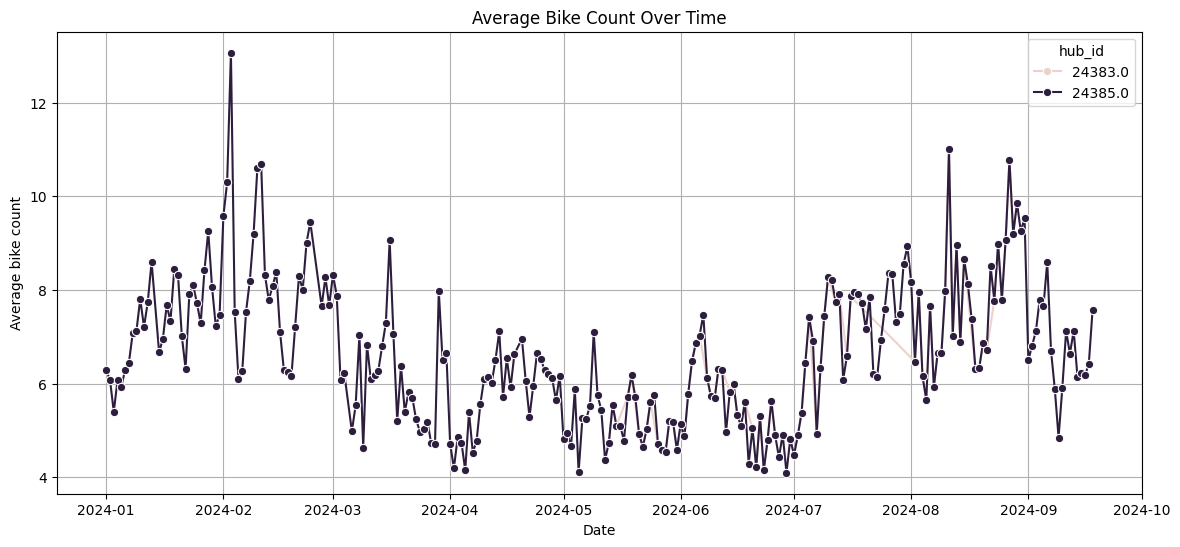

c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project_2024\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project_2024\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


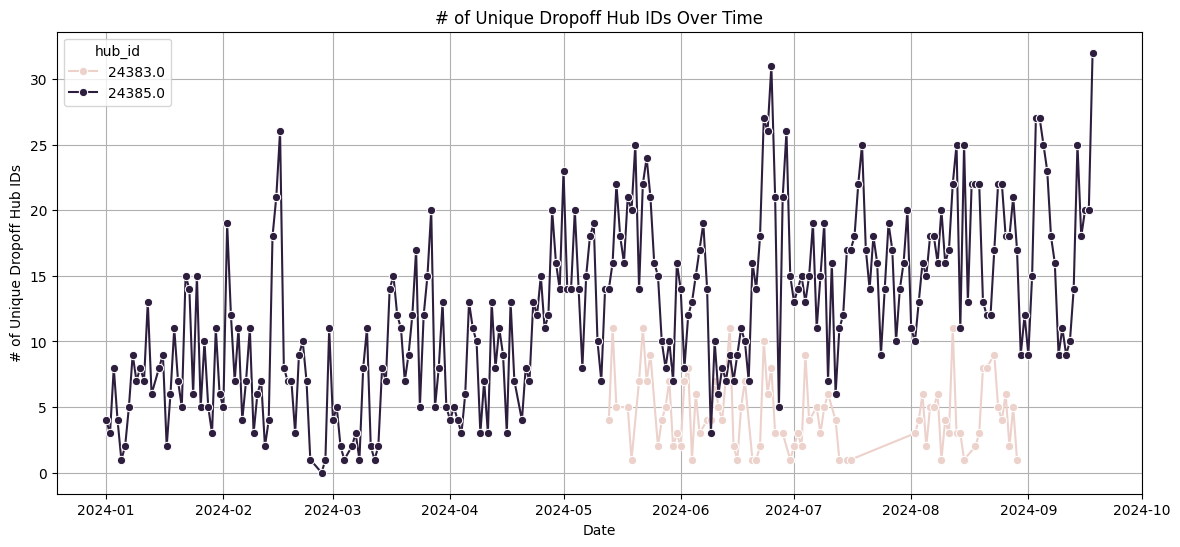

c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project_2024\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project_2024\.venv\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


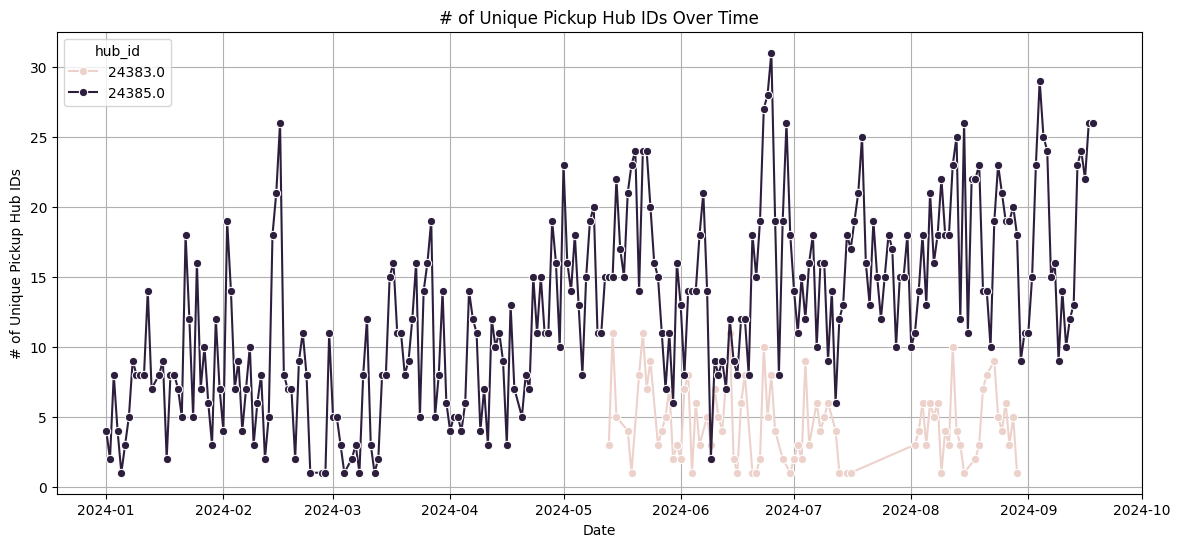

In [17]:
# Definieren Sie die Größe der Figure# Plot für Average bike_count
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_filtered, x='Days in full_date', y='Average bike_count', hue='hub_id', marker='o')
plt.title('Average Bike Count Over Time')
plt.xlabel('Date')
plt.ylabel('Average bike count')
plt.grid(True)
plt.show()

# Plot für # of unique dropoff_hub_id
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_filtered, x='Days in full_date', y='# of unique dropoff_hub_id', hue='hub_id', marker='o', color="red")
plt.title('# of Unique Dropoff Hub IDs Over Time')
plt.xlabel('Date')
plt.ylabel('# of Unique Dropoff Hub IDs')
plt.grid(True)
plt.show()

# Plot für # of unique pickup_hub_id
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_filtered, x='Days in full_date', y='# of unique pickup_hub_id', hue='hub_id', marker='o', color="blue")
plt.title('# of Unique Pickup Hub IDs Over Time')
plt.xlabel('Date')
plt.ylabel('# of Unique Pickup Hub IDs')
plt.grid(True)
plt.show()

***
***
# Requests

## .env

In [19]:
# .env
config = dotenv.dotenv_values(".env")

PASSWORD = config["PASSWORD"]

CLIENT_SECRET = config["CLIENT_SECRET"]

In [20]:
token_url = 'https://accounts.kielregion.addix.io/realms/infoportal/protocol/openid-connect/token'
headers = {
    'Content-Type': 'application/x-www-form-urlencoded'
}

data = {
    'grant_type': 'password',
    'username': 'justus.heilingbrunner@student.fh-kiel.de', 
    'password': PASSWORD,
    'client_id': 'quantumleap',
    'client_secret': CLIENT_SECRET
}

response = requests.post(token_url, headers=headers, data=data)

if response.status_code == 200:
    token_data = response.json()
    access_token = token_data['access_token']
    print(f"Bearer Token successful requested")
    if access_token:
        dotenv_path = '.env'
        
        dotenv.set_key(dotenv_path, 'ACCESS_TOKEN', access_token)
        print(f"Access Token erfolgreich in die .env-Datei geschrieben.")
else:
    print(f"Error: {response.status_code}, {response.text}")

Bearer Token successful requested
Access Token erfolgreich in die .env-Datei geschrieben.


In [21]:
config = dotenv.dotenv_values(".env")

ACCESS_TOKEN = config["ACCESS_TOKEN"]

***
## actual Request - bike

In [42]:
# request without attrs to get all avalable attrs

url = "https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:BikeHireDockingStation:KielRegion:30151"

params = {
    'type': 'BikeHireDockingStation',
    'fromDate': '2024-09-13T00:00:00',
    'toDate': '2024-09-13T00:02:05',
    # 'attrs': 'name,location',
    # 'aggrPeriod': 'hour',
    # 'aggrMethod': 'avg'
}

headers = {
    'NGSILD-Tenant': 'infoportal',
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    response_data = response.json()
    print('got a response')
else:
    print(f"Error: {response.status_code}, {response.text}")

got a response


In [43]:
response_data

{'attributes': [{'attrName': 'address', 'values': [None, None]},
  {'attrName': 'agency_fare_url',
   'values': [None, 'https://www.donkey.bike/pricing/']},
  {'attrName': 'agency_name', 'values': [None, 'Donkey Republic Kiel']},
  {'attrName': 'agency_url',
   'values': [None, 'https://www.donkey.bike/cities/bike-rental-kiel/']},
  {'attrName': 'areaServed', 'values': [None, '866']},
  {'attrName': 'availableBikeNumber', 'values': [8, 8]},
  {'attrName': 'contactPoint',
   'values': [None,
    {'email': 'support@donkeyrepublic.com',
     'name': 'Donkey Republic Kiel',
     'telephone': '+49 30 255 585617',
     'url': 'https://www.donkey.bike/cities/bike-rental-kiel/'}]},
  {'attrName': 'description', 'values': [None, None]},
  {'attrName': 'freeSlotNumber', 'values': [7, 7]},
  {'attrName': 'location',
   'values': [None, {'coordinates': [10.127872, 54.424663], 'type': 'Point'}]},
  {'attrName': 'location_centroid', 'values': [None, '54.424663, 10.127872']},
  {'attrName': 'name', '

***
## actual request - wetterdaten

In [24]:
# request without attrs to get all avalable attrs

url = "https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:WeatherObserved:OWM:5430967"

params = {
    'type': 'WeatherObserved',
    'fromDate': '2024-12-10T12:00:00',
    'toDate': '2024-12-10T16:02:00',
    'attrs': 'temperature,windSpeed,precipitation',
    'aggrPeriod': 'hour',
    'aggrMethod': 'avg'
}

headers = {
    'NGSILD-Tenant': 'infoportal',
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    response_data = response.json()
    print('got a response')
else:
    print(f"Error: {response.status_code}, {response.text}")

got a response


In [25]:
response_data

{'attributes': [{'attrName': 'precipitation', 'values': [0.0, 0.0, 0.0, 0.0]},
  {'attrName': 'temperature',
   'values': [4.6275, 4.58, 4.303333333333334, 3.9675000000000002]},
  {'attrName': 'windSpeed', 'values': [4.5625, 5.14, 3.94, 4.375]}],
 'entityId': 'urn:ngsi-ld:WeatherObserved:OWM:5430967',
 'entityType': 'WeatherObserved',
 'index': ['2024-12-10T12:00:00.000+00:00',
  '2024-12-10T13:00:00.000+00:00',
  '2024-12-10T14:00:00.000+00:00',
  '2024-12-10T15:00:00.000+00:00']}

***
## more requests

In [52]:
url = "https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:BikeHireDockingStation:KielRegion:24367"

params = {
    'type': 'BikeHireDockingStation',
    'fromDate': '2024-12-09T19:00:00',
    'toDate': '2024-12-09T21:01:05',
    # 'attrs': 'availableBikeNumber, totalSlotNumber, freeSlotNumber', #'name,location,totalSlotNumber', 
    # 'aggrPeriod': 'hour',
    # 'aggrMethod': 'avg'
}

headers = {
    'NGSILD-Tenant': 'infoportal',
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    response_data = response.json()
    print('got a response')
else:
    print(f"Error: {response.status_code}, {response.text}")

got a response


In [53]:
response_data

{'attributes': [{'attrName': 'address',
   'values': [None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,


In [54]:
response_data['attributes']

[{'attrName': 'address',
  'values': [None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
  

In [55]:
for attribute in response_data['attributes']:
    if attribute['attrName'] == 'location':
        print(attribute['values'][1]['coordinates'])
    elif attribute['attrName'] == 'name':
        print(attribute['values'][1])

[10.178556, 54.329611]
Anleger Dietrichsdorf


In [56]:
def attributes_to_dataframe_with_index(data, attribute_names):
    # Dictionary to store attribute values
    extracted_data = {}
    
    # Extract entityId and entityType
    entity_id = data.get('entityId', '')
    entity_type = data.get('entityType', '')

    # Extract the number after "KielRegion" from the entityId
    match = re.search(r'KielRegion:(\d+)', entity_id)
    entity_id_number = match.group(1) if match else ''  # Get the number or set to empty if not found

    # Loop through each attribute dictionary in 'attributes'
    for attribute in data.get('attributes', []):
        attr_name = attribute.get('attrName')
        if attr_name in attribute_names:
            extracted_data[attr_name] = attribute.get('values', [])

    # Extract the index from the response
    index_values = data.get('index', [])
    
    # Create a pandas DataFrame from the dictionary
    df = pd.DataFrame(extracted_data)
    
    # Add the index values, entityId number, and entityType as new columns
    df['index'] = index_values
    df['entityId'] = entity_id_number
    df['entityType'] = entity_type
    
    # Reorder the columns to have 'index', 'entityId', and 'entityType' first if desired
    column_order = ['index', 'entityId', 'entityType'] + attribute_names
    df = df[column_order]

    return df


In [57]:
# Example usage
attribute_names = ['availableBikeNumber', 'totalSlotNumber', 'freeSlotNumber']

# Assuming 'data' is your JSON response parsed as a Python dictionary
df = attributes_to_dataframe_with_index(response_data, attribute_names)

# Display the resulting DataFrame
df

,index,entityId,entityType,availableBikeNumber,totalSlotNumber,freeSlotNumber
0,2024-12-09T19:00:13.248+00:00,24367,BikeHireDockingStation,20,30,8
1,2024-12-09T19:01:14.458+00:00,24367,BikeHireDockingStation,20,30,8
2,2024-12-09T19:02:17.517+00:00,24367,BikeHireDockingStation,20,30,8
3,2024-12-09T19:03:15.979+00:00,24367,BikeHireDockingStation,20,30,8
4,2024-12-09T19:04:35.574+00:00,24367,BikeHireDockingStation,20,30,8
...,...,...,...,...,...,...
130,2024-12-09T20:57:25.290+00:00,24367,BikeHireDockingStation,20,30,8
131,2024-12-09T20:58:06.126+00:00,24367,BikeHireDockingStation,20,30,8
132,2024-12-09T20:58:48.015+00:00,24367,BikeHireDockingStation,20,30,8
133,2024-12-09T20:59:28.339+00:00,24367,BikeHireDockingStation,20,30,8


***
## get station informations

In [139]:
url = "https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:BikeHireDockingStation:KielRegion:26889"

ids = [
    30467, 30466, 30464, 30434, 30420, 30390, 30282, 30207, 30185,
    30156, 30155, 30151, 30147, 30146, 30145, 30126, 30121, 30120,
    30095, 30084, 30027, 30026, 30025, 30024, 30023, 30022, 30011,
    29982, 29974, 29965, 29964, 29963, 29946, 29942, 29941, 29940,
    29939, 29938, 29937, 29936, 29935, 29934, 29933, 29745, 29663,
    29347, 29346, 29345, 29253, 29224, 29200, 29198, 29147, 29112,
    29109, 29083, 29049, 28932, 28814, 28813, 28812, 28811, 28804,
    28803, 28802, 28801, 28800, 28799, 28798, 28797, 28796, 28795,
    28794, 28793, 28792, 28791, 28790, 28789, 28749, 28738, 28264,
    27717, 27567, 27452, 27451, 27450, 27449, 27448, 27447, 27446,
    27445, 27444, 27443, 27442, 27441, 27440, 27382, 27381, 27380,
    27379, 27378, 27377, 27376, 27375, 27374, 27373, 27372, 27209,
    27183, 26889, 26805, 26730, 26725, 26724, 26708, 26653, 26224,
    26209, 24602, 24482, 24481, 24479, 24478, 24477, 24476, 24475,
    24474, 24473, 24472, 24471, 24470, 24469, 24468, 24467, 24466,
    24465, 24464, 24463, 24462, 24461, 24460, 24459, 24458, 24457,
    24456, 24455, 24454, 24453, 24452, 24451, 24450, 24449, 24448,
    24447, 24446, 24445, 24444, 24443, 24442, 24441, 24440, 24439,
    24438, 24437, 24436, 24435, 24434, 24433, 24432, 24431, 24430,
    24429, 24428, 24427, 24426, 24425, 24424, 24423, 24422, 24421,
    24420, 24419, 24418, 24417, 24416, 24415, 24414, 24413, 24412,
    24411, 24410, 24409, 24408, 24407, 24406, 24405, 24404, 24403,
    24402, 24401, 24400, 24399, 24398, 24397, 24396, 24395, 24394,
    24393, 24392, 24391, 24390, 24389, 24388, 24387, 24386, 24385,
    24384, 24383, 24381, 24380, 24379, 24378, 24377, 24376, 24375,
    24374, 24373, 24372, 24371, 24370, 24369, 24368, 24367
]

params = {
    'type': 'BikeHireDockingStation',
    'fromDate': '2024-09-13T00:00:00',
    'toDate': '2024-09-13T00:02:00',
    'attrs': 'name,location',
    # 'aggrPeriod': 'hour',
    # 'aggrMethod': 'avg'
    }

headers = {
    'NGSILD-Tenant': 'infoportal',
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}


def get_parameter_from_response(response):
    response_data = response.json()

    for attribute in response_data['attributes']:
        if attribute['attrName'] == 'name':
            name = attribute['values'][1]
        elif attribute['attrName'] == 'location':
            location = attribute['values'][1]['coordinates']
        
    return(name, location)


# Über alle IDs iterieren und eine Anfrage für jede ID machen
results = []
for bike_id in ids:
    url = f"https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:BikeHireDockingStation:KielRegion:{bike_id}"

    try:
        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 200:
            # print(f"Response received for ID {bike_id}")
            name, location = get_parameter_from_response(response)
            results.append({'ID': bike_id, 'Status': 1, 'Name': name, 'Longitude': location[0], 'Latitude': location[1]})
        else:
            # print(f"Error: {response.status_code} for ID {bike_id}")
            results.append({'ID': bike_id, 'Status': 0, 'Name': None, 'Longitude': None, 'Latitude': None})

    except requests.exceptions.RequestException as e:
        # print(f"Request failed for ID {bike_id}")
        results.append({'ID': bike_id, 'Status': 2, 'Name': None, 'Longitude': None, 'Latitude': None})


df_results = pd.DataFrame(results)
# print(df_results.head())
# 0 = response error
# 1 = response received
# 2 = request failed

# Wiederhole den Prozess für alle IDs mit Status 2
while True:
    failed_df = df_results[df_results['Status'] == 2]
    failed_ids = failed_df['ID'].tolist()

    # Breche die Schleife ab, wenn es keine fehlgeschlagenen IDs mehr gibt
    if not failed_ids:
        break

    print(f"Retrying failed requests for IDs: {failed_ids}")

    results = []
    for bike_id in failed_ids:
        url = f"https://apis.kielregion.addix.io/ql/v2/entities/urn:ngsi-ld:BikeHireDockingStation:KielRegion:{bike_id}"

        try:
            response = requests.get(url, headers=headers, params=params)

            if response.status_code == 200:
                # print(f"Response received for ID {bike_id}")
                name, location = get_parameter_from_response(response)
                results.append({'ID': bike_id, 'Status': 1, 'Name': name, 'Longitude': location[0], 'Latitude': location[1]})
            else:
                # print(f"Error: {response.status_code} for ID {bike_id}")
                results.append({'ID': bike_id, 'Status': 0, 'Name': None, 'Longitude': None, 'Latitude': None})

        except requests.exceptions.RequestException as e:
            # print(f"Request failed for ID {bike_id}")
            results.append({'ID': bike_id, 'Status': 2, 'Name': None, 'Longitude': None, 'Latitude': None})

    new_results = pd.DataFrame(results)

    # Aktualisiere den ursprünglichen DataFrame mit den neuen Ergebnissen
    for index, row in new_results.iterrows():
        # df_results.loc[df_results['ID'] == row['ID'], ['Status', 'Name', 'Location']] = row['Status'], row['Name'], row['Location']
        df_results.loc[df_results['ID'] == row['ID'], 'Status'] = row['Status']
        df_results.loc[df_results['ID'] == row['ID'], 'Name'] = row['Name']
        df_results.loc[df_results['ID'] == row['ID'], 'Longitude'] = row['Longitude']
        df_results.loc[df_results['ID'] == row['ID'], 'Latitude'] = row['Latitude']


# Endgültige Resultate anzeigen
df_results.head()

Retrying failed requests for IDs: [30155, 30126, 30121, 30022, 29974, 29964, 29939, 29937, 29935, 29200, 28932, 28812, 28811, 28804, 28798, 28795, 28791, 28749, 27567, 27449, 27448, 27440, 27377, 27373, 27372, 26730, 26724, 26708, 24474, 24471, 24470, 24466, 24464, 24452, 24449, 24444, 24440, 24433, 24429, 24427, 24421, 24418, 24414, 24413, 24411, 24409, 24404, 24403, 24398, 24391, 24384, 24378, 24374, 24369]
Retrying failed requests for IDs: [30126, 30121, 29939, 29200, 28749, 27440, 26708, 24474, 24449, 24427, 24421, 24403, 24391, 24374]
Retrying failed requests for IDs: [30121, 28749, 24449, 24421]
Retrying failed requests for IDs: [28749, 24449]


,ID,Status,Name,Longitude,Latitude
0,30467,0,None,NaN,NaN
1,30466,0,None,NaN,NaN
2,30464,1,Pop Up Rathaus event,10.132222,54.322469
3,30434,1,Felde Gemeindezentrum,9.933817,54.299552
4,30420,0,None,NaN,NaN


In [140]:
new_results

,ID,Status,Name,Longitude,Latitude
0,28749,0,None,NaN,NaN
1,24449,1,Bebelplatz,10.185079,54.294629


In [147]:
df_results['Status'].value_counts()

Status
1    204
0     29
Name: count, dtype: int64

In [148]:
df_results.to_csv('Data/response_IDs_KielRegion.csv', index=False)
# 0 = response error
# 1 = response received
# 2 = request failed

***
***
# Felix datensatz einlesen

In [58]:
df = pd.read_csv('Data/FelixData_final_main_kiel.csv')
df.head()

,index,entityId,entityType,name,availableBikeNumber,freeSlotNumber,totalSlotNumber,pickups,dropoffs
0,2024-06-17T11:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.032787,25.000000,30.0,4627,4683
1,2024-06-17T12:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.762712,24.237288,30.0,4627,4683
2,2024-06-17T13:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.864407,24.000000,30.0,4627,4683
3,2024-06-17T14:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.846154,24.153846,30.0,4627,4683
4,2024-06-17T15:00:00.000+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.305556,24.694444,30.0,4627,4683


In [59]:
df['name'].nunique(), df['entityId'].nunique()

(36, 36)

In [60]:
df['name'].unique()

array(['Anleger Dietrichsdorf', 'Umsteiger', 'Alte Mu/Brunswiker Str.',
       'Alter Markt', 'Anleger Reventlou', 'Christian-Albrechts-Platz',
       'Hörnbad', 'Kirchhofallee', 'RBZ Wirtschaft', 'Vinetaplatz',
       'Westring/Eckernförder Str.', 'CAU Sportstätten', 'Dreiecksplatz',
       'Hansastr./Gutenbergstr.', 'Blücherplatz', 'Andreas-Gayk-Straße',
       'Tilsiter Platz', 'Wellingdorf Stadtteilzentrum', 'Hauptbahnhof',
       'Exerzierplatz', 'thyssenkrupp Marine Systems',
       'MEKUN Olympiahochhaus', 'Bernhard-Minetti-Platz',
       'KVG Betriebshof Diedrichstraße', 'Sophienhof', 'ADAC-Station',
       'Förde Sparkasse Lorentzendamm', 'Studiale', 'UKSH', 'Sandkrug',
       'Zur Fähre', 'Seefischmarkt', 'Krausstraße',
       'Kieler Innovations- und Technologiezentrum',
       ' Wik, Kanalfähre - Busstation', 'Wilhelmplatz'], dtype=object)

In [61]:
df['entityId'].unique()

array([24367, 24368, 24369, 24370, 24371, 24373, 24375, 24376, 24379,
       24380, 24381, 24383, 24385, 24389, 24391, 24392, 24393, 24395,
       24397, 24399, 24408, 24412, 24413, 24415, 24417, 24419, 24436,
       24457, 24465, 24466, 24467, 24469, 24471, 24481, 26224, 26889],
      dtype=int64)

# Stationen:

Alter Markt : 24370

In [62]:
df_alter_markt = df.loc[df['entityId'] == 24370]
df_alter_markt = df_alter_markt.reset_index(drop=True)
df_alter_markt['index'] = pd.to_datetime(df_alter_markt['index'])

print(df_alter_markt.shape)
df_alter_markt.head()

(2413, 9)


,index,entityId,entityType,name,availableBikeNumber,freeSlotNumber,totalSlotNumber,pickups,dropoffs
0,2024-06-17 11:00:00+00:00,24370,BikeHireDockingStation,Alter Markt,10.098361,13.000000,25.0,15439,15676
1,2024-06-17 12:00:00+00:00,24370,BikeHireDockingStation,Alter Markt,8.508475,14.491525,25.0,15439,15676
2,2024-06-17 13:00:00+00:00,24370,BikeHireDockingStation,Alter Markt,10.898305,12.203390,25.0,15439,15676
3,2024-06-17 14:00:00+00:00,24370,BikeHireDockingStation,Alter Markt,11.181818,12.000000,25.0,15439,15676
4,2024-06-17 15:00:00+00:00,24370,BikeHireDockingStation,Alter Markt,10.555556,12.444444,25.0,15439,15676


In [63]:
df_alter_markt['index'].iloc[0], df_alter_markt['index'].iloc[-1]

(Timestamp('2024-06-17 11:00:00+0000', tz='UTC'),
 Timestamp('2024-09-30 23:00:00+0000', tz='UTC'))

In [64]:
df_alter_markt = df_alter_markt[['index', 'availableBikeNumber']]
df_alter_markt.head()

,index,availableBikeNumber
0,2024-06-17 11:00:00+00:00,10.098361
1,2024-06-17 12:00:00+00:00,8.508475
2,2024-06-17 13:00:00+00:00,10.898305
3,2024-06-17 14:00:00+00:00,11.181818
4,2024-06-17 15:00:00+00:00,10.555556


Hauptbahnhof : 24397

In [65]:
df_hauptbahnhof = df.loc[df['entityId'] == 24397]
df_hauptbahnhof = df_hauptbahnhof.reset_index(drop=True)
df_hauptbahnhof['index'] = pd.to_datetime(df_hauptbahnhof['index'])

print(df_hauptbahnhof.shape)
df_hauptbahnhof.head()

(2412, 9)


,index,entityId,entityType,name,availableBikeNumber,freeSlotNumber,totalSlotNumber,pickups,dropoffs
0,2024-06-17 11:00:00+00:00,24397,BikeHireDockingStation,Hauptbahnhof,0.508475,78.762712,80.0,57838,57410
1,2024-06-17 12:00:00+00:00,24397,BikeHireDockingStation,Hauptbahnhof,5.932203,73.762712,80.0,57838,57410
2,2024-06-17 13:00:00+00:00,24397,BikeHireDockingStation,Hauptbahnhof,11.728814,67.440678,80.0,57838,57410
3,2024-06-17 14:00:00+00:00,24397,BikeHireDockingStation,Hauptbahnhof,15.642857,64.071429,80.0,57838,57410
4,2024-06-17 15:00:00+00:00,24397,BikeHireDockingStation,Hauptbahnhof,30.083333,47.750000,80.0,57838,57410


In [66]:
df_hauptbahnhof['index'].iloc[0], df_hauptbahnhof['index'].iloc[-1]

(Timestamp('2024-06-17 11:00:00+0000', tz='UTC'),
 Timestamp('2024-09-30 23:00:00+0000', tz='UTC'))

In [67]:
df_hauptbahnhof = df_hauptbahnhof[['index', 'availableBikeNumber']]
df_hauptbahnhof.head()

,index,availableBikeNumber
0,2024-06-17 11:00:00+00:00,0.508475
1,2024-06-17 12:00:00+00:00,5.932203
2,2024-06-17 13:00:00+00:00,11.728814
3,2024-06-17 14:00:00+00:00,15.642857
4,2024-06-17 15:00:00+00:00,30.083333


Anleger Dietrichsdorf : 24367

In [68]:
df_anleger_dietrichsdorf = df.loc[df['entityId'] == 24367]
df_anleger_dietrichsdorf = df_anleger_dietrichsdorf.reset_index(drop=True)
df_anleger_dietrichsdorf['index'] = pd.to_datetime(df_anleger_dietrichsdorf['index'])

print(df_anleger_dietrichsdorf.shape)
df_anleger_dietrichsdorf.head()

(2411, 9)


,index,entityId,entityType,name,availableBikeNumber,freeSlotNumber,totalSlotNumber,pickups,dropoffs
0,2024-06-17 11:00:00+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.032787,25.000000,30.0,4627,4683
1,2024-06-17 12:00:00+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.762712,24.237288,30.0,4627,4683
2,2024-06-17 13:00:00+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,6.864407,24.000000,30.0,4627,4683
3,2024-06-17 14:00:00+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.846154,24.153846,30.0,4627,4683
4,2024-06-17 15:00:00+00:00,24367,BikeHireDockingStation,Anleger Dietrichsdorf,5.305556,24.694444,30.0,4627,4683


In [69]:
df_anleger_dietrichsdorf['index'].iloc[0], df_anleger_dietrichsdorf['index'].iloc[-1]

(Timestamp('2024-06-17 11:00:00+0000', tz='UTC'),
 Timestamp('2024-09-30 23:00:00+0000', tz='UTC'))

In [70]:
df_anleger_dietrichsdorf = df_anleger_dietrichsdorf[['index', 'availableBikeNumber']]
df_anleger_dietrichsdorf.head()

,index,availableBikeNumber
0,2024-06-17 11:00:00+00:00,5.032787
1,2024-06-17 12:00:00+00:00,6.762712
2,2024-06-17 13:00:00+00:00,6.864407
3,2024-06-17 14:00:00+00:00,5.846154
4,2024-06-17 15:00:00+00:00,5.305556


## info diagrams

In [71]:
df_alter_markt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2413 entries, 0 to 2412
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   index                2413 non-null   datetime64[ns, UTC]
 1   availableBikeNumber  2413 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 37.8 KB


In [72]:
# nice to have: temp, wind speed, rainfall, sunshine?, Holiday, Student Holiday, Seasons, unique dropoffs, unique pickups

df_alter_markt_engineered = df_alter_markt.copy()

df_alter_markt_engineered['index'] = pd.to_datetime(df_alter_markt_engineered['index'])

# feature engineering
df_alter_markt_engineered['Year'] = df_alter_markt_engineered['index'].dt.year
df_alter_markt_engineered['Month'] = df_alter_markt_engineered['index'].dt.month_name()
df_alter_markt_engineered['Day'] = df_alter_markt_engineered['index'].dt.day              
df_alter_markt_engineered['DayOfWeek'] = df_alter_markt_engineered['index'].dt.day_name()
df_alter_markt_engineered['Hour'] = df_alter_markt_engineered['index'].dt.hour  # Stunde des Tages im 24-Stunden-Format
df_alter_markt_engineered['Season'] = df_alter_markt_engineered['index'].dt.month % 12 // 3 + 1  # Jahreszeit (1=Winter, 2=Frühling, 3=Sommer, 4=Herbst)
df_alter_markt_engineered['DayOfYear'] = df_alter_markt_engineered['index'].dt.dayofyear
df_alter_markt_engineered['Weekend'] = df_alter_markt_engineered['index'].dt.weekday >= 5  # boolean value for weekend (saturday=5, sunday=6)

# rearange columns
new_column_order = ['index', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'DayOfYear', 'Season',
                    'availableBikeNumber', 'Weekend']

df_alter_markt_engineered = df_alter_markt_engineered[new_column_order]


# Ausgabe anzeigen
df_alter_markt_engineered.head()

,index,Year,Month,Day,Hour,DayOfWeek,DayOfYear,Season,availableBikeNumber,Weekend
0,2024-06-17 11:00:00+00:00,2024,June,17,11,Monday,169,3,10.098361,False
1,2024-06-17 12:00:00+00:00,2024,June,17,12,Monday,169,3,8.508475,False
2,2024-06-17 13:00:00+00:00,2024,June,17,13,Monday,169,3,10.898305,False
3,2024-06-17 14:00:00+00:00,2024,June,17,14,Monday,169,3,11.181818,False
4,2024-06-17 15:00:00+00:00,2024,June,17,15,Monday,169,3,10.555556,False


In [73]:
# # df = pd.get_dummies(df, columns=['Season'], prefix='Season')
# df_alter_markt_model_2_dummified = pd.get_dummies(df_alter_markt_model_2, columns=['Season', 'DayOfWeek'], prefix=['Season', 'DayOfWeek'], drop_first=True)

# print(df_alter_markt_model_2_dummified.shape)
# df_alter_markt_model_2_dummified.head()

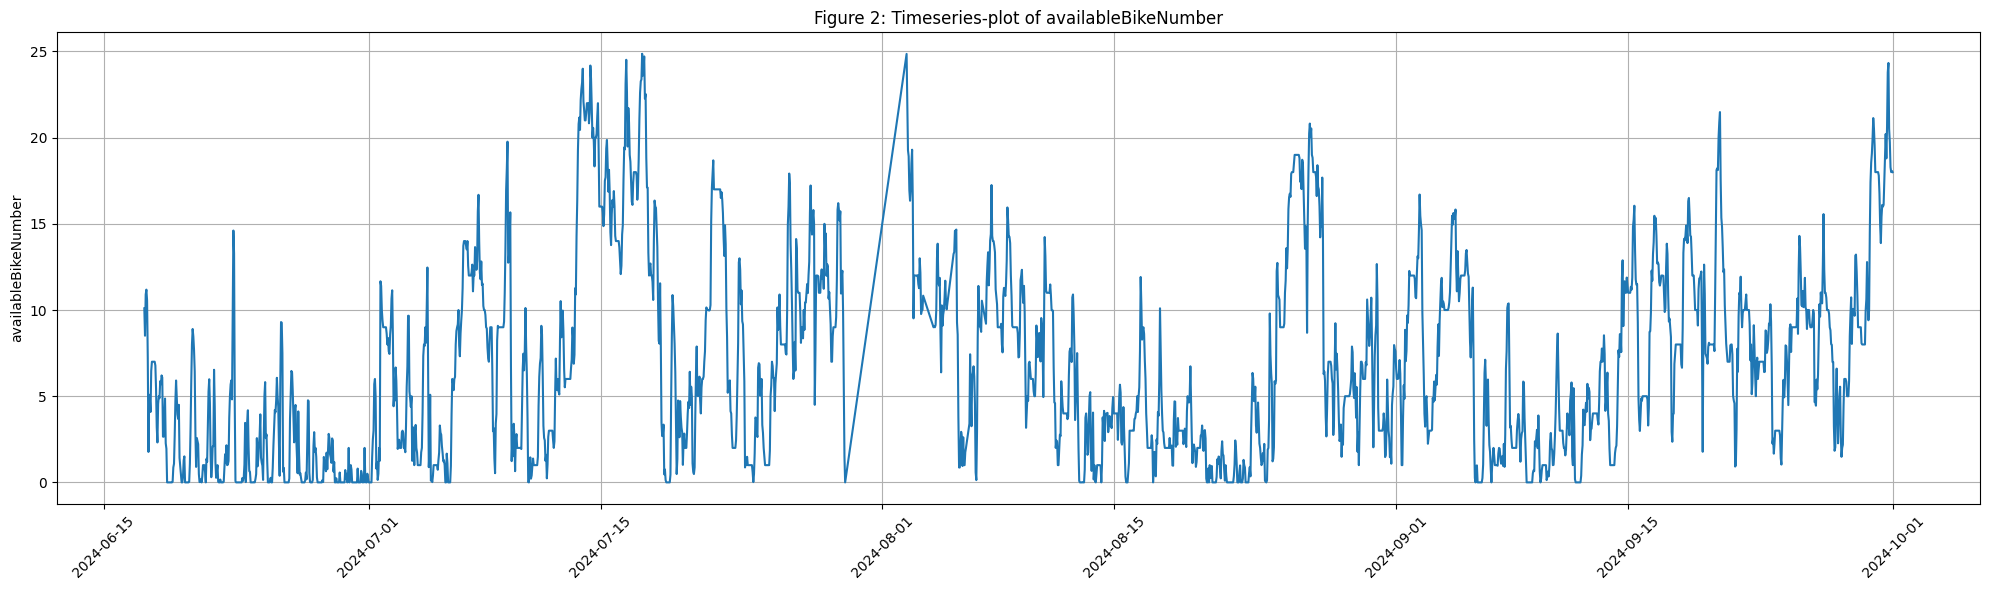

In [74]:
# timeplot
df_plot = df_alter_markt_engineered.copy()

# df_plot['Datetime'] = df_plot['index'] + pd.to_timedelta(df_plot['Hour'], unit='h')

plt.figure(figsize=(20, 6))
plt.plot(df_plot['index'], df_plot['availableBikeNumber'])

plt.title('Figure 2: Timeseries-plot of availableBikeNumber')
# plt.xlabel('Date and Hour')
plt.ylabel('availableBikeNumber')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

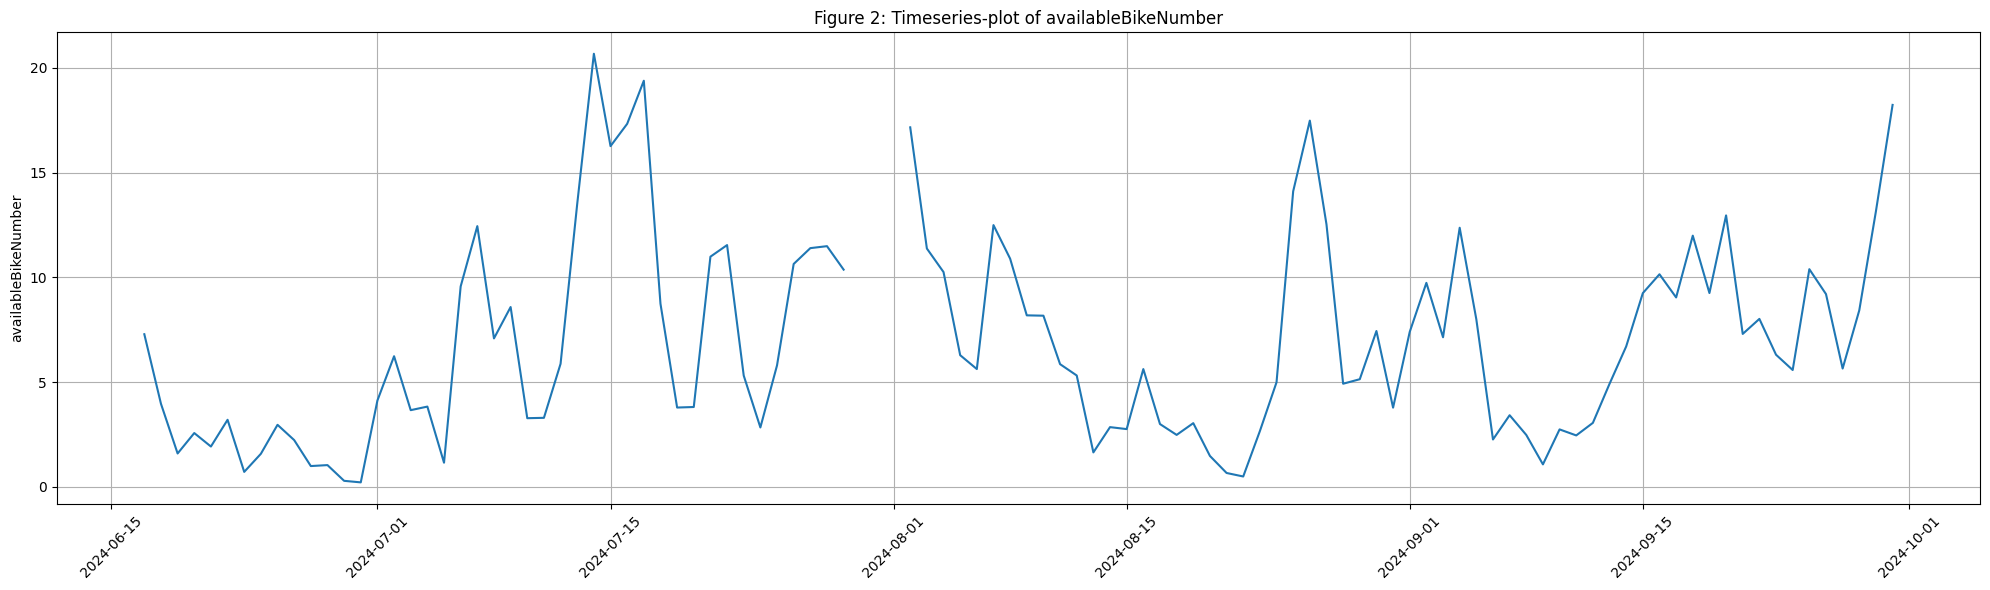

In [75]:
# timeplot

daily_data = df_plot.resample('D', on='index')['availableBikeNumber'].mean()

plt.figure(figsize=(20, 6))
# plt.plot(df_plot['Datetime'], df_plot['Rented Bike Count'])
plt.plot(daily_data.index, daily_data.values)

plt.title('Figure 2: Timeseries-plot of availableBikeNumber')
# plt.xlabel('Date and Hour')
plt.ylabel('availableBikeNumber')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

In [76]:
def draw_heatmap_by_metric_and_feature(dataframe, metric, feature, figure_number):

    # Compute average metric per hour
    pivot = dataframe.pivot_table(index='Hour', columns=feature, values=metric, aggfunc='mean').fillna(0)

    if feature == 'DayOfWeek':
        pivot = pivot.reindex(columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    
    if feature == 'Month':
        pivot = pivot.reindex(columns=['January', 'February', 'March', 'April', 'May', 'June',
                                       'July', 'August', 'September', 'October', 'November', 'December'])
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(pivot, fmt=".0f", cmap='YlGnBu', annot=True, cbar_kws={'label': metric}, linewidths=0.5)
    
    ax.set_title(f'Figure {figure_number}: Heatmap of Average {metric} by Hour and {feature}')
    ax.set_xlabel('')
    ax.set_ylabel('Hour')
    
    plt.tight_layout()
    plt.show()

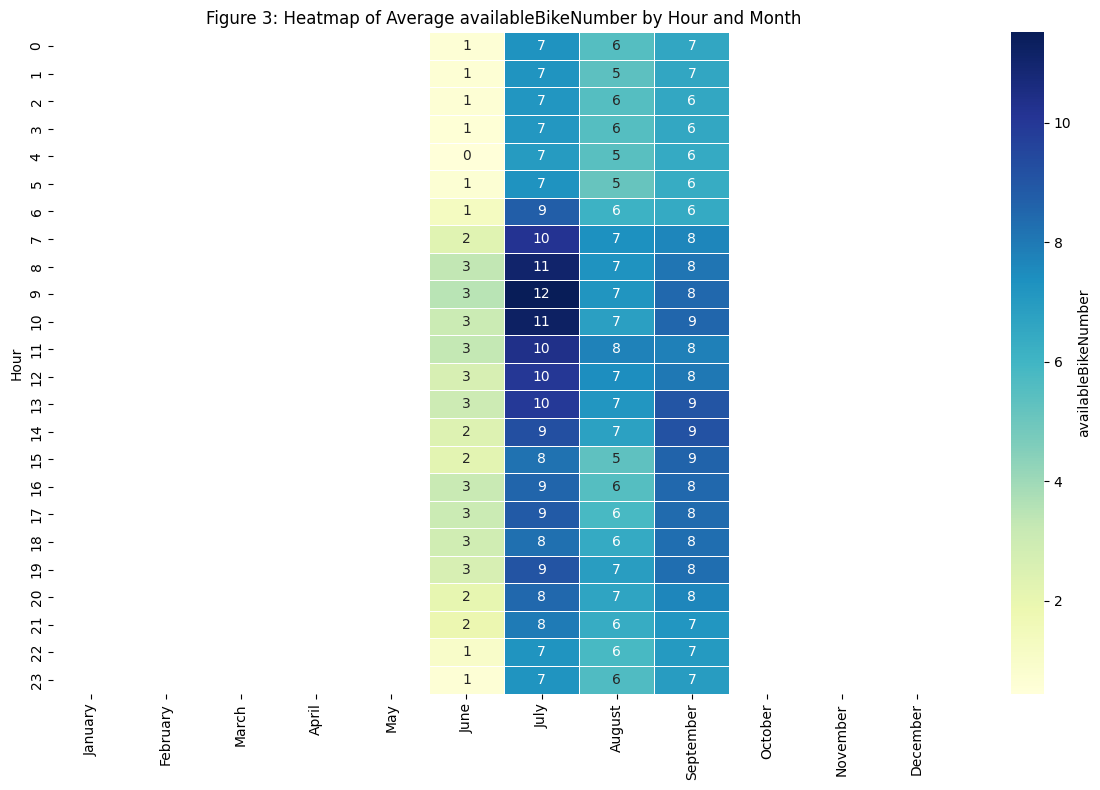

In [77]:
draw_heatmap_by_metric_and_feature(df_plot, 'availableBikeNumber', 'Month', 3)

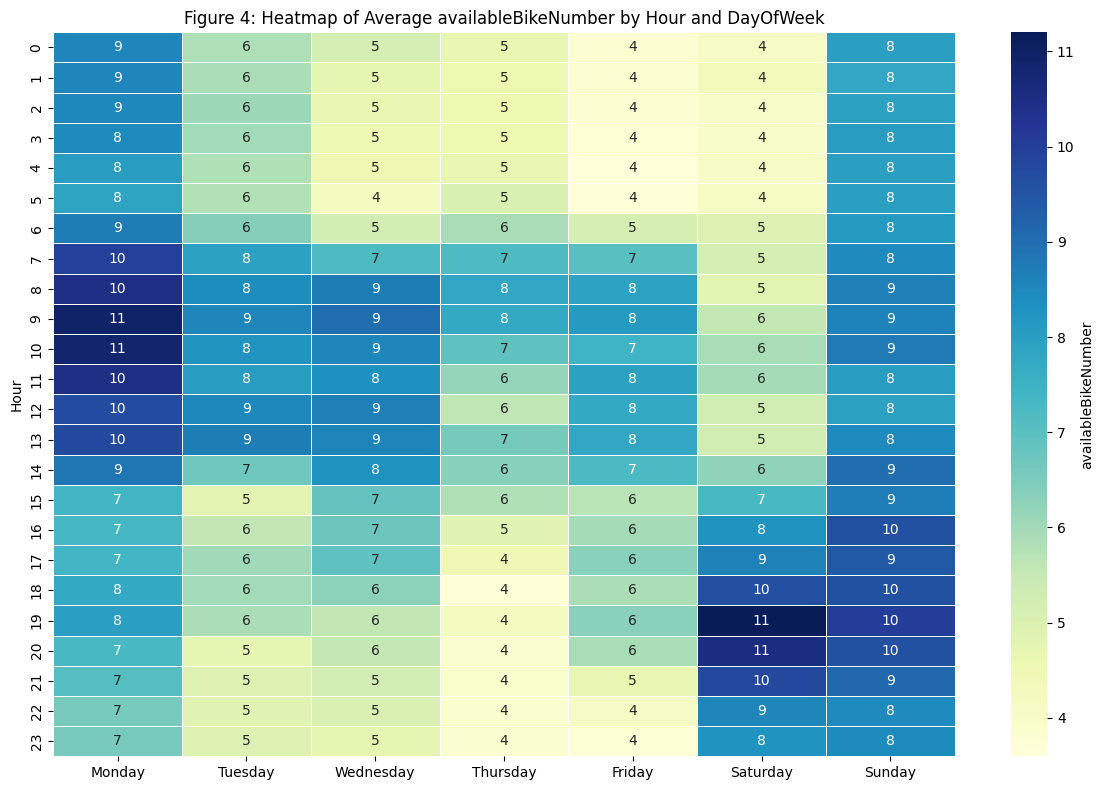

In [78]:
draw_heatmap_by_metric_and_feature(df_plot, 'availableBikeNumber', 'DayOfWeek', 4)

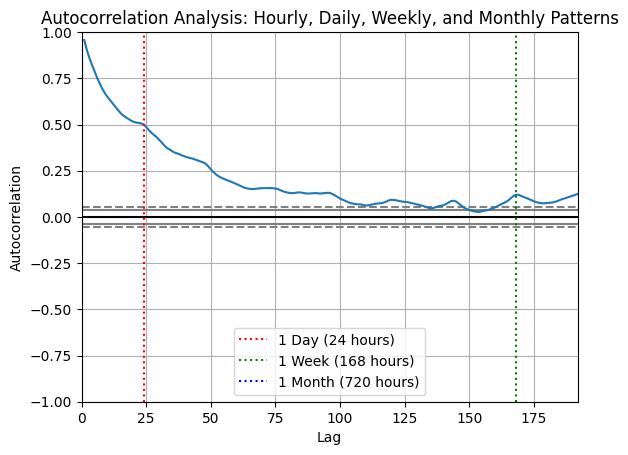

In [79]:
# check for patterns with auto correlation
# make auto correlation
# by hour (done)
# by day
# by month

# Calculate autocorrelation
ax = autocorrelation_plot(df_plot['availableBikeNumber'])
ax.set_title('Autocorrelation Analysis: Hourly, Daily, Weekly, and Monthly Patterns')
ax.set_xlim([0, 24 * 8])  # View up to 30 days for long-term cycles

# Add vertical lines for different periods
plt.axvline(24, linestyle=':', color='r', label='1 Day (24 hours)')
plt.axvline(24*7, linestyle=':', color='g', label='1 Week (168 hours)')
plt.axvline(24*30, linestyle=':', color='b', label='1 Month (720 hours)')

plt.legend()

plt.show()

In [80]:
# make dickey-fuller test for stationary
# test statistic -> timeseries is / is not stationary
# we want stationarity 
# if not we make .diff()
# do fuller test again
# 

def print_ad_fuller(timeseries):
    ad_fuller_res = adfuller(timeseries)
    print('ADF Statistic: %f' % ad_fuller_res[0])
    print('p-value: %f' % ad_fuller_res[1])
    print('Critical Values:')
    for key, value in ad_fuller_res[4].items():
        print('\t%s: %.3f' % (key, value))

In [81]:
print ("Augmented Dickey–Fuller Test for original time series")
print_ad_fuller(df_plot['availableBikeNumber'])

Augmented Dickey–Fuller Test for original time series
ADF Statistic: -4.389913
p-value: 0.000309
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


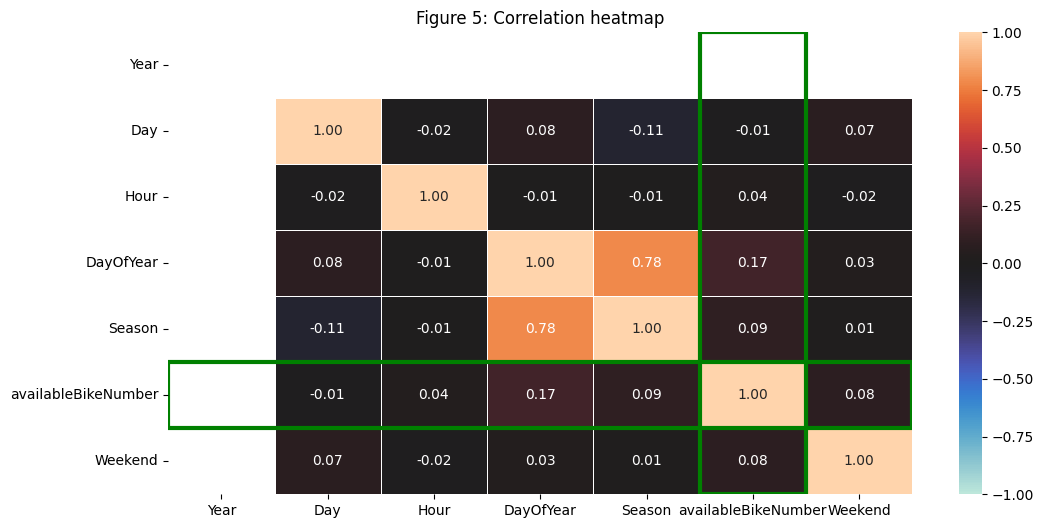

In [82]:
# plot correlation between parameter with sns.heatmap

corrs = df_plot.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(corrs, annot=True, fmt=".2f", ax=ax, linewidth=.5, center=0, vmin=-1, vmax=1)

index = corrs.columns.get_loc('availableBikeNumber')

rect_col = patches.Rectangle((index, 0), 1, corrs.shape[0], linewidth=3, edgecolor='green', facecolor='none')
rect_row = patches.Rectangle((0, index), corrs.shape[1], 1, linewidth=3, edgecolor='green', facecolor='none')

ax.add_patch(rect_col)
ax.add_patch(rect_row)

ax.set_title('Figure 5: Correlation heatmap')
plt.show()

***
## multivariaten daten und n step prediction

### functions

In [83]:
def count_params(model):
    '''
    Return the number of trainable parameters of a PyTorch Module (model)
    Iterate each of the modules parameters and counts them 
    if they require grad (if they are trainable)
    '''
    if isinstance(model, nn.Module):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return 0

In [84]:
# Train a model using training data
# Evaluate on validation data
# store a checkpoint for the configuration that performed best on validation 
def train(model, num_epochs, learning_rate, loss_function, trainX, trainY, valX, valY):
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_loss=float("inf")
    best_model_dict=model.state_dict()
    best_epoch=0
    
    model.train()
    
    for epoch in range(num_epochs):
        trainY_pred = model(trainX)  # predict train with the current model
        optimizer.zero_grad()
    
        train_loss = loss_function(trainY_pred, trainY) # compute the loss ("how bad is our model?")
    
        train_loss.backward() # propagate the loss backwards through the network
    
        optimizer.step() # update weights and biases
    
        with torch.no_grad():
            valY_pred=model(valX)
            val_loss=loss_function(valY_pred,valY)
            if (val_loss<best_val_loss):
                best_val_loss=val_loss
                best_model_dict=copy.deepcopy(model.state_dict())
                best_epoch=epoch
            
        if epoch % 1000 == 999:
            print("Epoch: %d, loss: %1.5f, val_loss: %1.5f" % (epoch, train_loss.item(), val_loss.item()))
    model.load_state_dict(best_model_dict)
    print("Best Epoch: %d, loss: %1.5f" % (best_epoch, best_val_loss.item()))
    return model

In [85]:
# Use the model to predict for the values in the test set
# Return the prediction
def predict(model, testX):
    model.eval()
    with torch.no_grad():
        return model(testX)

In [86]:
def inverse_scale_target(scaler, scaled_target, target_feature_index, original_feature_count):
    # Prepare a dummy matrix with zeros
    dummy = np.zeros((scaled_target.shape[0], original_feature_count))

    # Place scaled target feature where it originally belonged in full dataset
    dummy[:, target_feature_index] = scaled_target.flatten()

    # Use inverse_transform, which applies only to non-zero entries when split like this
    inversed_full = scaler.inverse_transform(dummy)

    # Extract only the inversely transformed target value
    return inversed_full[:, target_feature_index]

In [87]:
# Add evaluation measures to the dataframe result_df
# NOTE: At this stage, we are working with a differenced time series, thus metrics like mape make no sense!
def add_result_multivariate_prediction_length(result_df, predictions, model, model_name, criterion, scaler, testY_pred, testY, trainY_pred, trainY, training_time, feature_index, feature_count):
    # Check if index entries for the model and datasets exist, otherwise add them
    if (model_name, 'Train') not in result_df.index:
        result_df.loc[(model_name, 'Train'), :] = [np.nan] * len(result_df.columns)
    if (model_name, 'Test') not in result_df.index:
        result_df.loc[(model_name, 'Test'), :] = [np.nan] * len(result_df.columns)
    
    # Train
    # Reshape and inverse scale train predictions
    num_samples, prediction_length, _ = trainY_pred.shape
    trainY_pred_reshaped = trainY_pred.reshape(num_samples * prediction_length, -1)
    trainY_reshaped = trainY.reshape(num_samples * prediction_length, -1)
    
    # Inverse transform for target feature predictions
    trainY_pred_bikes = inverse_scale_target(scaler, trainY_pred_reshaped, feature_index, feature_count).reshape(num_samples, prediction_length, -1)
    trainY_bikes = inverse_scale_target(scaler, trainY_reshaped, feature_index, feature_count).reshape(num_samples, prediction_length, -1)

    result_df.loc[(model_name, 'Train'), 'Loss'] = criterion(trainY_pred, trainY).item() # compute the loss using the given criterion
    result_df.loc[(model_name, 'Train'), "MSE"] = mean_squared_error(trainY_bikes.flatten(), trainY_pred_bikes.flatten())
    result_df.loc[(model_name, 'Train'), "MAE"] = mean_absolute_error(trainY_bikes.flatten(), trainY_pred_bikes.flatten())
    result_df.loc[(model_name, 'Train'), "MAPE"] = mean_absolute_percentage_error(trainY_bikes.flatten(), trainY_pred_bikes.flatten()) * 100 # implemented is relative to 1 not to 100
    # result_df.loc[(model_name, 'Train'), "Avg. hourly available bike number deviation"] = round(abs_bikes_diff/len(trainY_bikes), 1)
    result_df.loc[(model_name, 'Train'), "Parameters"] = int(count_params(model))
    result_df.loc[(model_name, 'Train'), "Training_Time_in_sec"] = round(training_time)

    # Test
    # Reshape and inverse scale test predictions
    num_samples, prediction_length, _ = testY_pred.shape
    testY_pred_reshaped = testY_pred.reshape(num_samples * prediction_length, -1)
    testY_reshaped = testY.reshape(num_samples * prediction_length, -1)
    
    # Inverse transform for target feature predictions
    testY_pred_bikes = inverse_scale_target(scaler, testY_pred_reshaped, feature_index, feature_count).reshape(num_samples, prediction_length, -1)
    testY_bikes = inverse_scale_target(scaler, testY_reshaped, feature_index, feature_count).reshape(num_samples, prediction_length, -1)

    result_df.loc[(model_name, 'Test'), 'Loss'] = criterion(testY_pred, testY).item() # compute the loss using the given criterion
    result_df.loc[(model_name, 'Test'), "MSE"] = mean_squared_error(testY_bikes.flatten(), testY_pred_bikes.flatten())
    result_df.loc[(model_name, 'Test'), "MAE"] = mean_absolute_error(testY_bikes.flatten(), testY_pred_bikes.flatten())
    result_df.loc[(model_name, 'Test'), "MAPE"] = mean_absolute_percentage_error(testY_bikes.flatten(), testY_pred_bikes.flatten()) * 100 # implemented is relative to 1 not to 100
    # result_df.loc[(model_name, 'Test'), "Avg. hourly available bike number deviation"] = round(abs_bikes_diff/len(testY_bikes), 1)
    result_df.loc[(model_name, 'Test'), "Parameters"] = int(count_params(model) if model is not None else 0)

    # Store predictions
    prediction_df = pd.DataFrame({model_name: [testY_pred_bikes[i, :, 0] for i in range(num_samples)]})
    if (predictions.empty):
        actual_df = pd.DataFrame({'actual': [testY_bikes[i, :, 0] for i in range(num_samples)]})
        predictions['actual'] = actual_df['actual']
    predictions[model_name] = prediction_df[model_name]

    print('--Training time: ', round(training_time), 'seconds')
    print(f'Added results for {model_name} to dataframe.')

In [88]:
def sliding_windows_multivarate_prediction_length(data, seq_length, prediction_length): 
    x = []
    y = []

    for i in range(len(data) - seq_length - prediction_length + 1): 
        _x = data[i:(i + seq_length), :]
        _y = data[i + seq_length:i + seq_length + prediction_length, 0]  # Assuming target is the first feature
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [89]:
# create the machine learning experimental setup (scale data, create sliding windows, split into train-, validation-, and test-data
def setup_experiment_multivariate_prediction_length(dataset, seq_len, test_share, val_share, scaler, prediction_length):

    scaled_data = scaler.fit_transform(dataset)
    
    x, y = sliding_windows_multivarate_prediction_length(scaled_data, seq_len, prediction_length)
    used_vec_length = len(y)
    # y = y.reshape(-1, 1)
    y = y[:, :, np.newaxis]

    test_size = int(used_vec_length * test_share)
    val_size = int(used_vec_length * val_share)
    train_size = used_vec_length - test_size-val_size
    index_val_start = train_size
    index_test_start = train_size + val_size

    x_train = x[0:index_val_start]
    y_train = y[0:index_val_start]
    x_val = x[index_val_start:index_test_start]
    y_val = y[index_val_start:index_test_start]
    x_test = x[index_test_start:used_vec_length]
    y_test = y[index_test_start:used_vec_length]
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [90]:
# Predict the average of the most recent n elements of x
def baseline_avg_pred_n_steps_multivariate_prediction_length(x, n, feature_index, prediction_length_steps):
    avg_values = torch.Tensor(np.mean(x[:, -n:, feature_index], axis=1)).reshape(-1, 1)
    avg_values = avg_values.view(-1, 1, 1)

    return avg_values.expand(-1, prediction_length_steps, -1)

# Predict the value of last n hours
def baseline_last_n_steps_multivariate_prediction_length(x, n, feature_index, prediction_length_steps):
    return torch.Tensor(x[:,-n:-(n - prediction_length_steps), feature_index]).unsqueeze(-1)

# Predict 0 as new value
def baseline_zero_multivariate_prediction_length(x, scaler, feature_index, feature_count, prediction_length_steps):

    scaled_zero_value = scaler.transform(np.zeros((1, feature_count)))[0, feature_index]

    return torch.Tensor(np.full((len(x), prediction_length_steps, 1), scaled_zero_value))

### experiment alter markt

- change model structure, hyperparameters etc
- add features (weather)
- add hybrid lstm (linear layer for categorial data)

In [91]:
print(df_alter_markt.shape)
df_alter_markt.head()

(2413, 2)


,index,availableBikeNumber
0,2024-06-17 11:00:00+00:00,10.098361
1,2024-06-17 12:00:00+00:00,8.508475
2,2024-06-17 13:00:00+00:00,10.898305
3,2024-06-17 14:00:00+00:00,11.181818
4,2024-06-17 15:00:00+00:00,10.555556


In [100]:
df_alter_markt_engineered = df_alter_markt.copy()

df_alter_markt_engineered['index'] = pd.to_datetime(df_alter_markt_engineered['index'])

df_alter_markt_engineered['Month'] = df_alter_markt_engineered['index'].dt.month_name()
df_alter_markt_engineered['Hour'] = df_alter_markt_engineered['index'].dt.hour  # Stunde des Tages im 24-Stunden-Format
df_alter_markt_engineered['DayOfYear'] = df_alter_markt_engineered['index'].dt.dayofyear
df_alter_markt_engineered['DayOfWeek'] = df_alter_markt_engineered['index'].dt.day_name()
df_alter_markt_engineered['Weekend'] = df_alter_markt_engineered['index'].dt.weekday >= 5 

df_alter_markt_engineered.head()

,index,availableBikeNumber,Month,Hour,DayOfYear,DayOfWeek,Weekend
0,2024-06-17 11:00:00+00:00,10.098361,June,11,169,Monday,False
1,2024-06-17 12:00:00+00:00,8.508475,June,12,169,Monday,False
2,2024-06-17 13:00:00+00:00,10.898305,June,13,169,Monday,False
3,2024-06-17 14:00:00+00:00,11.181818,June,14,169,Monday,False
4,2024-06-17 15:00:00+00:00,10.555556,June,15,169,Monday,False


In [104]:
df_alter_markt_dummified = pd.get_dummies(df_alter_markt_engineered,
                              columns=['Month', 'DayOfWeek', 'Weekend'],
                              prefix=['Month', 'DayOfWeek', 'Weekend'],
                              drop_first=True)

df_alter_markt_dummified.head()

# df_alter_markt_dummified = df_alter_markt_engineered.copy()
# df_alter_markt_dummified.head()

,index,availableBikeNumber,Hour,DayOfYear,Month_July,Month_June,Month_September,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Weekend_True
0,2024-06-17 11:00:00+00:00,10.098361,11,169,False,True,False,True,False,False,False,False,False,False
1,2024-06-17 12:00:00+00:00,8.508475,12,169,False,True,False,True,False,False,False,False,False,False
2,2024-06-17 13:00:00+00:00,10.898305,13,169,False,True,False,True,False,False,False,False,False,False
3,2024-06-17 14:00:00+00:00,11.181818,14,169,False,True,False,True,False,False,False,False,False,False
4,2024-06-17 15:00:00+00:00,10.555556,15,169,False,True,False,True,False,False,False,False,False,False


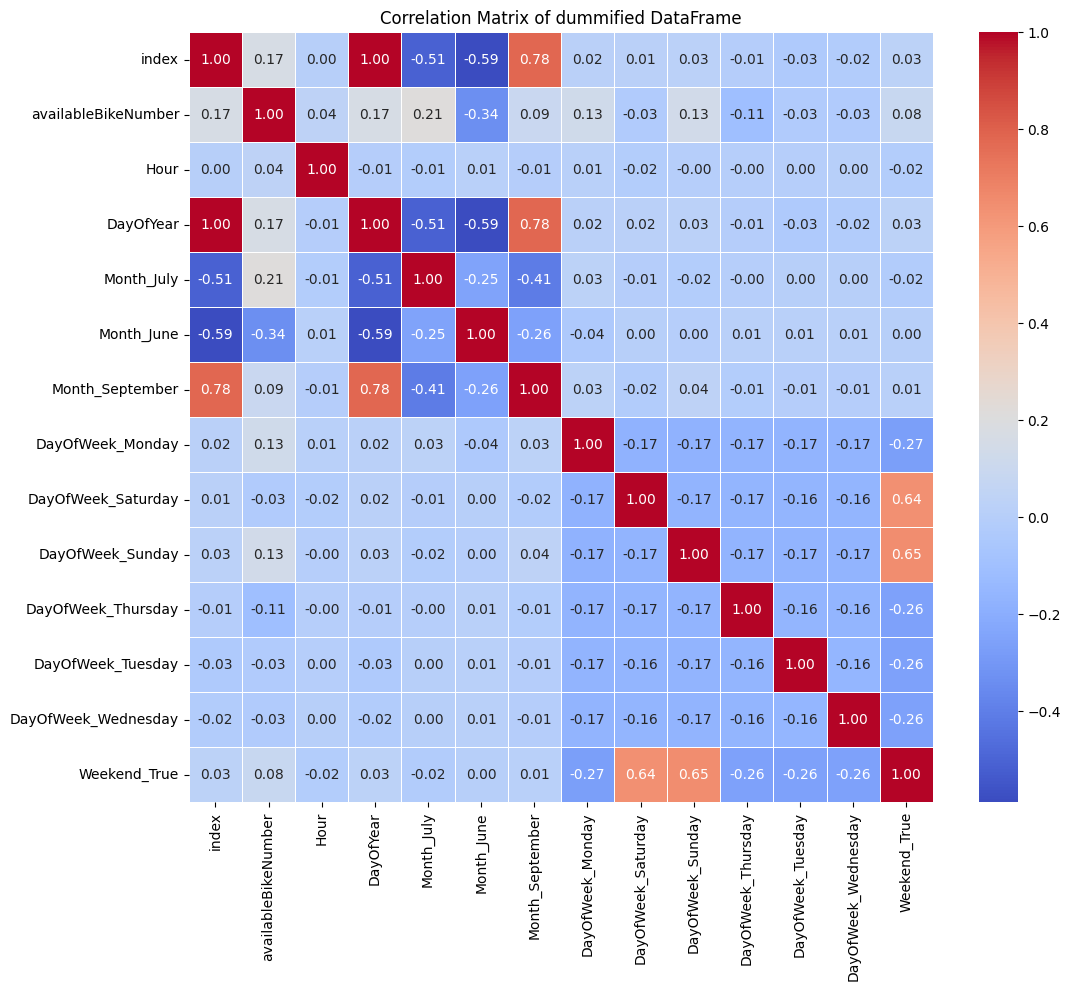

In [105]:
correlation_matrix = df_alter_markt_dummified.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix of dummified DataFrame')
plt.show()

In [106]:
target = df_alter_markt_engineered.loc[:, ["availableBikeNumber"]]
full_dataset = df_alter_markt_dummified.drop(['index'], axis=1)

print('Mean of availableBikeNumber: ', np.sum(target['availableBikeNumber'])/len(target))
# full_dataset = target['availableBikeNumber'].values.reshape(-1,1) # reshape because the scaler expects a 2D array

Mean of availableBikeNumber:  6.812880388077202


In [107]:
print(full_dataset.shape)
full_dataset.head()

(2413, 13)


,availableBikeNumber,Hour,DayOfYear,Month_July,Month_June,Month_September,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Weekend_True
0,10.098361,11,169,False,True,False,True,False,False,False,False,False,False
1,8.508475,12,169,False,True,False,True,False,False,False,False,False,False
2,10.898305,13,169,False,True,False,True,False,False,False,False,False,False
3,11.181818,14,169,False,True,False,True,False,False,False,False,False,False
4,10.555556,15,169,False,True,False,True,False,False,False,False,False,False


In [108]:
datasetname = 'df_alter_markt'

sc = MinMaxScaler()
criterion = nn.MSELoss() # loss function: mean-squared error for regression
activation = torch.nn.ReLU()
sliding_window_width = 24 # sliding window width is actually a hyperparameter of the training setup
prediction_length_steps = 5 # how many next steps to predict

original_feature_count = full_dataset.shape[1] # ????????? full_dataset.shape[1]
target_feature_index = 0

# predictions, result = do_experiments_multivariate(datasetname, sc, criterion, activation, sliding_window_width, look_ahead_steps, full_dataset, target_feature_index, original_feature_count)
x_train, y_train, x_val, y_val, x_test, y_test = setup_experiment_multivariate_prediction_length(
        dataset = full_dataset,
        seq_len = sliding_window_width, # sliding window width = 48 hours
        test_share = 0.2, 
        val_share = 0.2, 
        scaler = sc,
        prediction_length = prediction_length_steps)

trainX=torch.Tensor(x_train)
trainY=torch.Tensor(y_train)
valX=torch.Tensor(x_val)
valY=torch.Tensor(y_val)
testX=torch.Tensor(x_test)
testY=torch.Tensor(y_test)

print(datasetname)
print('')
print('Dataset Shape: ', full_dataset.shape)
print('Scaler: ', sc)
print('Loss Function (criterion): ', criterion)
print('Activation Function: ', activation)
print('Sliding Window Width: ', sliding_window_width)
print('Prediction Length Steps: ', prediction_length_steps)
print('Original Feature Count: ', original_feature_count)
print('Target Feature Index: ', target_feature_index)
print('-----------------')
print('x_train.shape: ', x_train.shape, ', y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape, ', y_test.shape: ', y_test.shape)
print('-----------------')
print("Dataset shape: ", full_dataset.shape)
print("Training shape: ", trainX.shape, trainY.shape)
print("Validation shape: ", valX.shape, valY.shape)
print("Testset shape: ", testX.shape, testY.shape)

predictions = pd.DataFrame()         # in this dictionary we will store the actual predictions for each model on the test data
result = pd.DataFrame()  # in this dataframe we will store the results of our methods on the test data

index = pd.MultiIndex.from_product([['avg_last_24_hours'], ['Train', 'Test']], names=['Model', 'Dataset'])
result = pd.DataFrame(columns=['Loss', 'MSE', 'MAE', 'MAPE'], index=index)

print('-----------------')
print('-----------------')
print('Doing Baselines')

testY_pred = baseline_avg_pred_n_steps_multivariate_prediction_length(x_test, 24, target_feature_index, prediction_length_steps)
trainY_pred = baseline_avg_pred_n_steps_multivariate_prediction_length(x_train, 24, target_feature_index, prediction_length_steps)
add_result_multivariate_prediction_length(result, predictions, None, "avg_last_24_hours", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0, target_feature_index, original_feature_count)

testY_pred = baseline_last_n_steps_multivariate_prediction_length(x_test, 24, target_feature_index, prediction_length_steps)
trainY_pred = baseline_last_n_steps_multivariate_prediction_length(x_train, 24, target_feature_index, prediction_length_steps)
add_result_multivariate_prediction_length(result, predictions, None, "last_day", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0, target_feature_index, original_feature_count)

testY_pred = baseline_zero_multivariate_prediction_length(x_test, sc, target_feature_index, original_feature_count, prediction_length_steps)
trainY_pred = baseline_zero_multivariate_prediction_length(x_train, sc, target_feature_index, original_feature_count, prediction_length_steps)
add_result_multivariate_prediction_length(result, predictions, None, "no-change", criterion, sc, testY_pred, testY, trainY_pred, trainY, 0, target_feature_index, original_feature_count)

print('-----------------')
print('Doing MLP')

# Training parameters
num_epochs = 10000
learning_rate = 0.1

# Model hyperparameters
# num_features = original_feature_count
input_size = sliding_window_width * original_feature_count
hidden_size = 6
dropout_prob = 0.2

class Perceptron(nn.Module):

    def __init__(self, input_size, hidden_size, dropout_prob):
        super(Perceptron, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.output_layer = nn.Linear(hidden_size, prediction_length_steps)


    def forward(self, x):  # x shape (dataset, time-steps, features)
        # x = x.squeeze(-1)    # x shape (dataset, time-steps)
        # Flatten the input: from (batch_size, time_steps, num_features) to (batch_size, time_steps * num_features)
        x = x.view(x.size(0), -1)
        
        hidden_layer_output = activation(self.hidden_layer(x))  #relu: x>0 -> x, x<=0 -> 0
        hidden_layer_output = self.dropout(hidden_layer_output)
        return self.output_layer(hidden_layer_output)
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('dropout probability: ', dropout_prob)
print('--Training...')

perceptron_model = Perceptron(input_size, hidden_size, dropout_prob)

start_time = time.time()
perceptron_model = train(perceptron_model, num_epochs, learning_rate, criterion, trainX, trainY.squeeze(-1), valX, valY.squeeze(-1))
training_time = time.time() - start_time

testY_pred = predict(perceptron_model, testX)
trainY_pred = predict(perceptron_model, trainX)
add_result_multivariate_prediction_length(result, predictions, perceptron_model, "MLP", criterion, sc, testY_pred.unsqueeze(-1), testY, trainY_pred.unsqueeze(-1), trainY, training_time, target_feature_index, original_feature_count)

print('-----------------')
print('Doing CNN')

# Training parameters
num_epochs = 10000
learning_rate = 0.01

# Model hyperparameters
input_size = sliding_window_width
in_channels = original_feature_count
out_channels = 2
kernel_size = 4
stride = 2
dropout_prob = 0.2

class ConvModel(nn.Module):

    def __init__(self, input_size, out_channels, kernel_size, stride, dropout_prob):
        super(ConvModel, self).__init__()
        
        self.input_size = input_size # size of features # sequence length, not feature count
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride)
        self.dropout = nn.Dropout(dropout_prob)
        self.conv1d_output_size=out_channels*math.floor((input_size-kernel_size)/stride +1)
        
        self.hidden_layer_size=int(self.conv1d_output_size/2)
        self.lin = nn.Linear(self.conv1d_output_size, self.hidden_layer_size)  
        self.lin2 = nn.Linear(self.hidden_layer_size, prediction_length_steps)  
        
        
    def forward(self, x):
        x_conv_output = activation(self.conv1d(x))
        x_reshape = x_conv_output.reshape(x_conv_output.size(0), -1)
        x_lin1 = activation(self.lin(x_reshape))
        x_lin1 = self.dropout(x_lin1)
        return self.lin2(x_lin1)
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('out_channels: ', out_channels)
print('kernel_size: ', kernel_size)
print('stride: ', stride)
print('dropout probability: ', dropout_prob)
print('--Training...')

cnn_model = ConvModel(input_size, out_channels, kernel_size, stride, dropout_prob)

start_time = time.time()
cnn_model = train(cnn_model, num_epochs, learning_rate, criterion, trainX.permute(0,2,1), trainY.squeeze(-1), valX.permute(0,2,1), valY.squeeze(-1))
training_time = time.time() - start_time

testY_pred = predict(cnn_model, testX.permute(0,2,1))
trainY_pred = predict(cnn_model, trainX.permute(0,2,1))
add_result_multivariate_prediction_length(result, predictions, cnn_model, "CNN", criterion, sc, testY_pred.unsqueeze(-1), testY, trainY_pred.unsqueeze(-1), trainY, training_time, target_feature_index, original_feature_count)

print('-----------------')
print('Doing LSTM')

# Training parameters
num_epochs = 5000
learning_rate = 0.02

# Model hyperparameters
input_size = original_feature_count
hidden_size = 2
dropout_prob = 0.2

class LstmModel(nn.Module):

    def __init__(self, input_size, hidden_size, dropout_prob):
        super(LstmModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(
            input_size=input_size,       # number of features of each input
            hidden_size=hidden_size,     # size of the hidden state and the cell state
            batch_first=True)            # input and output as (batch, seq, feature)
        self.dropout = nn.Dropout(dropout_prob)
        self.output_layer = nn.Linear(hidden_size, prediction_length_steps)  
        
        
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize hidden state before each pass
        
        c_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize cell state before each pass
        
        lstm_output, (h_out, c_out) = self.lstm(x, (h_0, c_0))  # lstm_output (batch,time-steps,hidden_size), h_out (layers,batch,hidden_size)
        lstm_output = self.dropout(lstm_output)
        return self.output_layer(lstm_output[:,-1,:])  # use only output of last time step
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('dropout probability: ', dropout_prob)
print('--Training...')

lstm_model = LstmModel(input_size, hidden_size, dropout_prob)

start_time = time.time()
lstm_model = train(lstm_model, num_epochs, learning_rate, criterion, trainX, trainY.squeeze(-1), valX, valY.squeeze(-1))
training_time = time.time() - start_time

testY_pred = predict(lstm_model, testX)
trainY_pred = predict(lstm_model, trainX)
add_result_multivariate_prediction_length(result, predictions, lstm_model, "LSTM", criterion, sc, testY_pred.unsqueeze(-1), testY, trainY_pred.unsqueeze(-1), trainY, training_time, target_feature_index, original_feature_count)

print('-----------------')
print('Doing GRU')

# Training parameters
num_epochs = 5000
learning_rate = 0.02

# Model hyperparameters
input_size = original_feature_count
hidden_size = 2
dropout_prob = 0.2

class GruModel(nn.Module):

    def __init__(self, input_size, hidden_size, dropout_prob):
        super(GruModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(
            input_size=input_size,       # number of features of each input
            hidden_size=hidden_size,     # size of the hidden state and the cell state
            batch_first=True)            # input and output as (batch, seq, feature)
        self.dropout = nn.Dropout(dropout_prob)
        self.output_layer = nn.Linear(hidden_size, prediction_length_steps)  
        
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size)  # initialize hidden state before each pass
                
        gru_out, h_out = self.gru(x, h_0)  # lstm_output (batch,time-steps,hidden_size), h_out (layers,batch,hidden_size)
        gru_out = self.dropout(gru_out)
        return self.output_layer(gru_out[:,-1,:])  # use only output of last time step
    
print('--Traing parameters')
print('num_epochs: ', num_epochs)
print('learning_rate: ', learning_rate)
print('--Model hyperparameters')
print('input_size: ', input_size)
print('hidden_size: ', hidden_size)
print('dropout probability: ', dropout_prob)
print('--Training...')

gru_model = GruModel(input_size, hidden_size, dropout_prob)

start_time = time.time()
gru_model = train(gru_model, num_epochs, learning_rate, criterion, trainX, trainY.squeeze(-1), valX, valY.squeeze(-1))
training_time = time.time() - start_time

testY_pred = predict(gru_model, testX)
trainY_pred = predict(gru_model, trainX)
add_result_multivariate_prediction_length(result, predictions, gru_model, "GRU", criterion, sc, testY_pred.unsqueeze(-1), testY, trainY_pred.unsqueeze(-1), trainY, training_time, target_feature_index, original_feature_count)


# hybrid lstm


predictions_df_alter_markt = predictions.copy()
result_df_alter_markt = result.copy()

df_alter_markt

Dataset Shape:  (2413, 13)
Scaler:  MinMaxScaler()
Loss Function (criterion):  MSELoss()
Activation Function:  ReLU()
Sliding Window Width:  24
Prediction Length Steps:  5
Original Feature Count:  13
Target Feature Index:  0
-----------------
x_train.shape:  (1431, 24, 13) , y_train.shape:  (1431, 5, 1)
x_test.shape:  (477, 24, 13) , y_test.shape:  (477, 5, 1)
-----------------
Dataset shape:  (2413, 13)
Training shape:  torch.Size([1431, 24, 13]) torch.Size([1431, 5, 1])
Validation shape:  torch.Size([477, 24, 13]) torch.Size([477, 5, 1])
Testset shape:  torch.Size([477, 24, 13]) torch.Size([477, 5, 1])
-----------------
-----------------
Doing Baselines
--Training time:  0 seconds
Added results for avg_last_24_hours to dataframe.
--Training time:  0 seconds
Added results for last_day to dataframe.
--Training time:  0 seconds
Added results for no-change to dataframe.
-----------------
Doing MLP
--Traing parameters
num_epochs:  10000
learning_rate:  0.1
--Model hyperpar

c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project_2024\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\JustusHeilingbrunner\Documents\UNI\WS_2024_25\Application_Project_2024\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch: 999, loss: 0.05564, val_loss: 0.04860
Epoch: 1999, loss: 0.05564, val_loss: 0.04860
Epoch: 2999, loss: 0.05564, val_loss: 0.04860
Epoch: 3999, loss: 0.05564, val_loss: 0.04860
Epoch: 4999, loss: 0.05564, val_loss: 0.04860
Epoch: 5999, loss: 0.05564, val_loss: 0.04860
Epoch: 6999, loss: 0.05564, val_loss: 0.04860
Epoch: 7999, loss: 0.05564, val_loss: 0.04860
Epoch: 8999, loss: 0.05568, val_loss: 0.04866
Epoch: 9999, loss: 0.05565, val_loss: 0.04867
Best Epoch: 82, loss: 0.04853
--Training time:  18 seconds
Added results for MLP to dataframe.
-----------------
Doing CNN
--Traing parameters
num_epochs:  10000
learning_rate:  0.01
--Model hyperparameters
input_size:  24
out_channels:  2
kernel_size:  4
stride:  2
dropout probability:  0.2
--Training...
Epoch: 999, loss: 0.03679, val_loss: 0.02798
Epoch: 1999, loss: 0.03735, val_loss: 0.02978
Epoch: 2999, loss: 0.03662, val_loss: 0.02936
Epoch: 3999, loss: 0.03652, val_loss: 0.02947
Epoch: 4999, loss: 0.03647, val_loss: 0.02988
Epoch

results

In [109]:
result_df_alter_markt.head(25)

Loss        MSE       MAE  \
Model             Dataset                                  
avg_last_24_hours Train    0.025103  15.522422  2.935948   
                  Test     0.026822  16.585533  3.226979   
last_day          Train    0.047058  29.098164  3.877995   
                  Test     0.051505  31.847893   4.53783   
no-change         Train    0.119898  74.139194  6.303384   
                  Test     0.154908  95.787701   8.57553   
MLP               Train    0.055693  34.437649  4.901294   
                  Test     0.043261  26.750308  4.046308   
CNN               Train    0.035214  21.774893  3.362452   
                  Test     0.041341   25.56351  4.072821   
LSTM              Train    0.012418   7.678767  2.063416   
                  Test     0.012976   8.023644   2.09032   
GRU               Train    0.011636   7.194939  1.958192   
                  Test      0.01999  12.361136  2.791054   

                                           MAPE  Parameters  \
Model             Dataset                                     
avg_last_24_hours Train    103247224575477360.0         0.0   
                  Test      21462606916662784.0         0.0   
last_day          Train     82693500693535488.0         0.0   
                  Test      22255022663186220.0         0.0   
no-change         Train               89.811321         0.0   
                  Test                98.322851         0.0   
MLP               Train    296244651914281024.0      1913.0   
                  Test      48765876343312672.0      1913.0   
CNN               Train     95241191724614336.0       419.0   
                  Test      13832227764424314.0       419.0   
LSTM              Train     97821494024841488.0       151.0   
                  Test       8191057150779411.0       151.0   
GRU               Train     78994364864440512.0       117.0   
                  Test       8174879211401150.0       117.0   

                           Training_Time_in_sec  
Model             Dataset                        
avg_last_24_hours Train                     0.0  
                  Test                      NaN  
last_day          Train                     0.0  
                  Test                      NaN  
no-change         Train                     0.0  
                  Test                      NaN  
MLP               Train                    18.0  
                  Test                      NaN  
CNN               Train                    32.0  
                  Test                      NaN  
LSTM              Train                    42.0  
                  Test                      NaN  
GRU               Train                   110.0  
                  Test                      NaN

plot predictions

In [110]:
predictions_df_alter_markt.shape

(477, 8)

In [111]:
predictions_df_alter_markt.head()

,actual,avg_last_24_hours,last_day,no-change,MLP,CNN,LSTM,GRU
0,"[2.9999999458591144, 2.9999999458591144, 2.999...","[2.6621940299868583, 2.6621940299868583, 2.662...","[1.000000043710073, 1.000000043710073, 1.00000...","[0.0, 0.0, 0.0, 0.0, 0.0]","[6.436636825402578, 6.578839808702469, 6.39813...","[2.591398420929909, 2.573972191413244, 2.71176...","[2.5773224487900737, 2.739979547262192, 2.8624...","[0.9997480750083924, 1.1943238645792007, 1.360..."
1,"[2.9999999458591144, 2.9999999458591144, 2.288...","[2.745527305205663, 2.745527305205663, 2.74552...","[1.000000043710073, 1.000000043710073, 0.13333...","[0.0, 0.0, 0.0, 0.0, 0.0]","[6.436636825402578, 6.578839808702469, 6.39813...","[2.2667604635159173, 2.2622817198435468, 2.416...","[2.554905756811301, 2.7190863395730656, 2.8426...","[0.8332864344120026, 1.0346209138631821, 1.207..."
2,"[2.9999999458591144, 2.288135561347008, 2.0000...","[2.8288605804244678, 2.8288605804244678, 2.828...","[1.000000043710073, 0.13333333761741717, 0.333...","[0.0, 0.0, 0.0, 0.0, 0.0]","[6.436636825402578, 6.578839808702469, 6.39813...","[1.9694355428218842, 1.9899632106224696, 2.170...","[3.104151764512062, 3.229475438594818, 3.32531...","[1.4219542423884075, 1.6079856991767885, 1.767..."
3,"[2.288135561347008, 2.000000087420146, 2.00000...","[2.9121940409143767, 2.9121940409143767, 2.912...","[0.13333333761741717, 0.33333333246409896, 0.6...","[0.0, 0.0, 0.0, 0.0, 0.0]","[6.436636825402578, 6.578839808702469, 6.39813...","[2.399282290538152, 2.4141606718301776, 2.5832...","[3.171117634574572, 3.2927010556062064, 3.3860...","[1.808799566825231, 1.9834961374600728, 2.1333..."
4,"[2.000000087420146, 2.000000087420146, 1.56666...","[3.001977344353994, 3.001977344353994, 3.00197...","[0.33333333246409896, 0.6333333363135656, 0.34...","[0.0, 0.0, 0.0, 0.0, 0.0]","[6.436636825402578, 6.578839808702469, 6.39813...","[2.486796949307124, 2.516879047950109, 2.69741...","[2.6394060547153155, 2.7984385093053183, 2.918...","[1.9078684727350872, 2.0775990366935733, 2.222..."


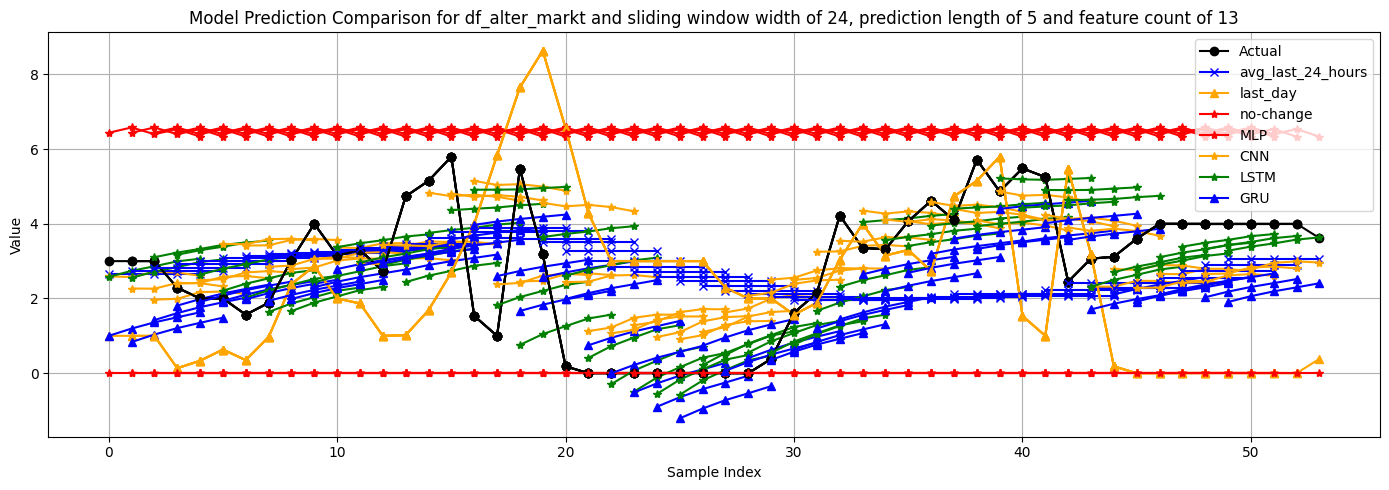

In [114]:
plt.figure(figsize=(14, 5))

num_rows_to_plot = 50

# Create sample lines for legend purposes only
plt.plot([], [], label='Actual', marker='o', color='black')
plt.plot([], [], label='avg_last_24_hours', marker='x', color='blue')
plt.plot([], [], label='last_day', marker='^', color='orange')
plt.plot([], [], label='no-change', marker='*', color='red')
plt.plot([], [], label='MLP', marker='*', color='red')
plt.plot([], [], label='CNN', marker='*', color='orange')
plt.plot([], [], label='LSTM', marker='*', color='green')
plt.plot([], [], label='GRU', marker='^', color='blue')

for i in range(num_rows_to_plot):
    x_values = np.arange(i, i + len(predictions_df_alter_markt['actual'][i]))

    plt.plot(x_values, predictions_df_alter_markt['actual'][i], marker='o', color='black')
    plt.plot(x_values, predictions_df_alter_markt['avg_last_24_hours'][i], marker='x', color='blue')
    plt.plot(x_values, predictions_df_alter_markt['last_day'][i], marker='^', color='orange')
    plt.plot(x_values, predictions_df_alter_markt['no-change'][i], marker='*', color='red')
    plt.plot(x_values, predictions_df_alter_markt['MLP'][i], marker='*', color='red')
    plt.plot(x_values, predictions_df_alter_markt['CNN'][i], marker='*', color='orange')
    plt.plot(x_values, predictions_df_alter_markt['LSTM'][i], marker='*', color='green')
    plt.plot(x_values, predictions_df_alter_markt['GRU'][i], marker='^', color='blue')

plt.title(f'Model Prediction Comparison for {datasetname} and sliding window width of {sliding_window_width}, prediction length of {prediction_length_steps} and feature count of {original_feature_count}')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
# plt.xticks(predictions.index)

plt.tight_layout()

# file_name = f'Results/JH_{datasetname}_diagram_{look_ahead_steps}_{sliding_window_width}.png'
# plt.savefig(file_name)

plt.show()

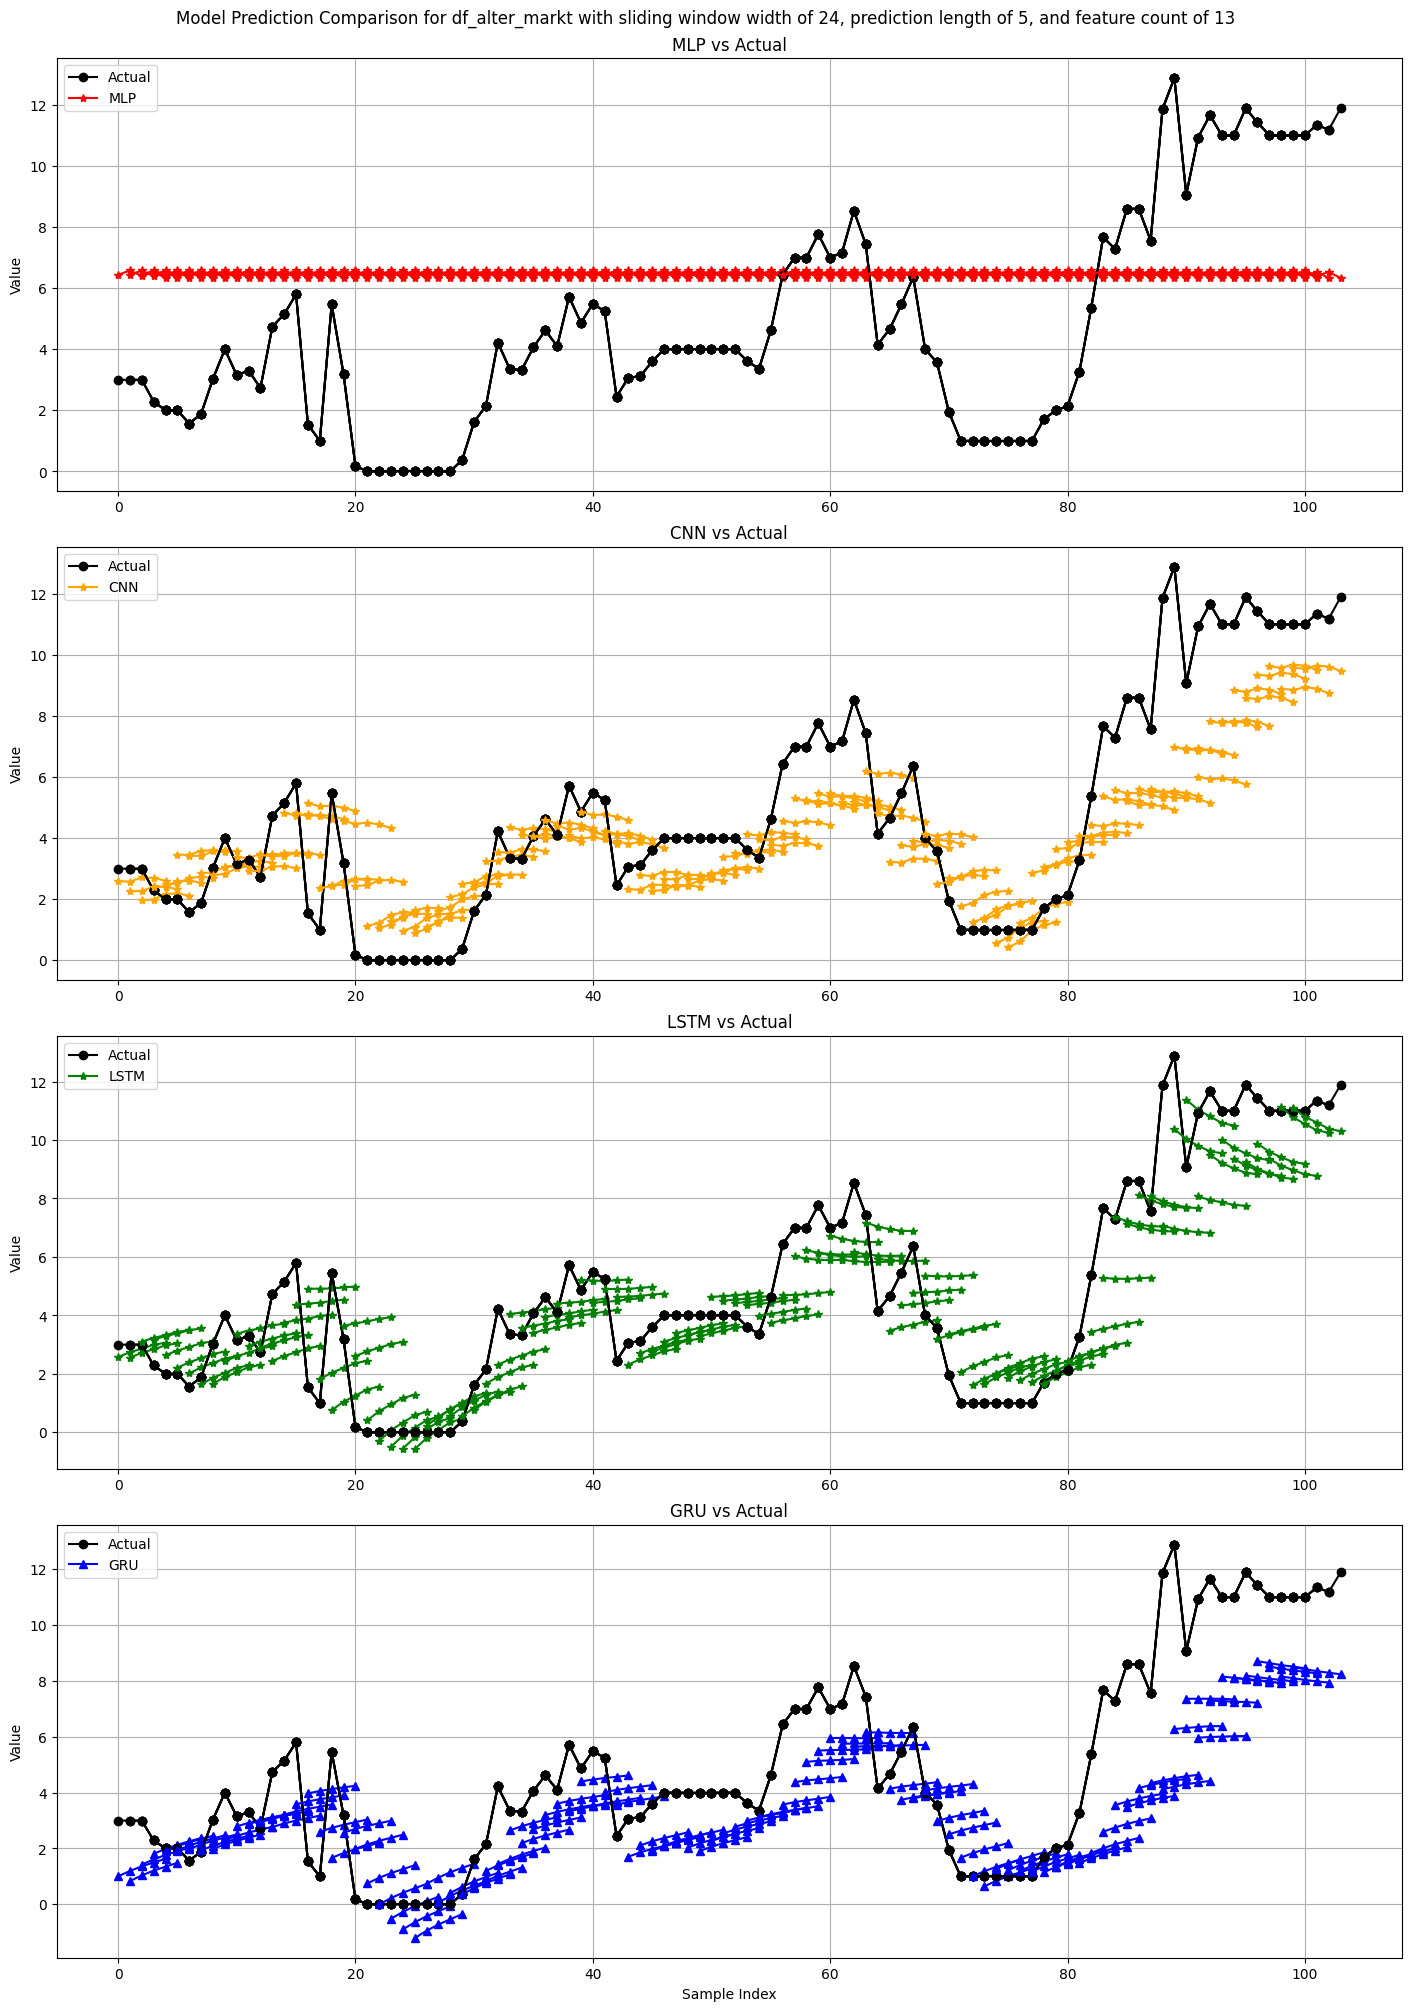

In [115]:
# Define the number of subplots
num_subplots = 4
fig, axs = plt.subplots(num_subplots, 1, figsize=(14, 5 * num_subplots), constrained_layout=True)

num_rows_to_plot = 100

# Define colors and markers for each model
colors = {'MLP': 'red', 'CNN': 'orange', 'LSTM': 'green', 'GRU': 'blue'}
markers = {'MLP': '*', 'CNN': '*', 'LSTM': '*', 'GRU': '^'}

model_names = ['MLP', 'CNN', 'LSTM', 'GRU']

for idx, model_name in enumerate(model_names):
    # Plotting actual values in the same subplot as each model
    axs[idx].plot([], [], label='Actual', marker='o', color='black')  # For legend
    axs[idx].plot([], [], label=model_name, marker=markers[model_name], color=colors[model_name])  # For legend
    
    for i in range(num_rows_to_plot):
        x_values = np.arange(i, i + len(predictions_df_alter_markt['actual'][i]))

        # Actual values
        axs[idx].plot(x_values, predictions_df_alter_markt['actual'][i], marker='o', color='black')

        # Model predictions
        axs[idx].plot(x_values, predictions_df_alter_markt[model_name][i], marker=markers[model_name], color=colors[model_name])
    
    axs[idx].set_title(f'{model_name} vs Actual')
    axs[idx].set_ylabel('Value')
    axs[idx].legend(loc='best')
    axs[idx].grid(True)

axs[-1].set_xlabel('Sample Index')

plt.suptitle(f'Model Prediction Comparison for {datasetname} with sliding window width of {sliding_window_width}, prediction length of {prediction_length_steps}, and feature count of {original_feature_count}')
# plt.xticks(predictions.index)  # Adjust if you want specific tick indices

# Save plot if needed
# file_name = f'Results/JH_{datasetname}_diagram_{look_ahead_steps}_{sliding_window_width}.png'
# plt.savefig(file_name)

plt.show()

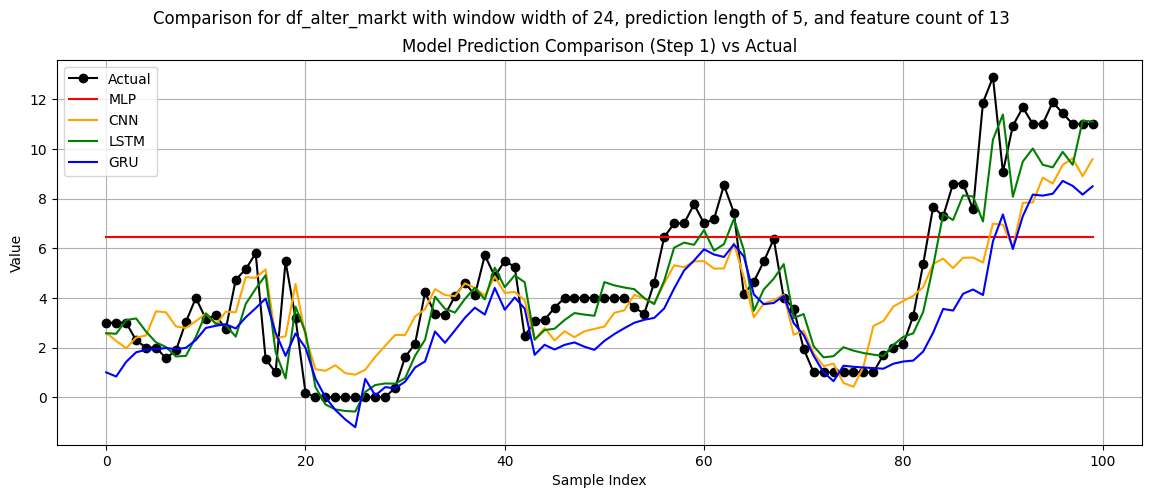

In [116]:
# Create a single subplot for comparison
fig, ax = plt.subplots(figsize=(14, 5))

# Number of rows you want to plot
num_rows_to_plot = 100

# Define colors and markers for each model
colors = {'MLP': 'red', 'CNN': 'orange', 'LSTM': 'green', 'GRU': 'blue'}
markers = {'MLP': '*', 'CNN': '*', 'LSTM': '*', 'GRU': '^'}

model_names = ['MLP', 'CNN', 'LSTM', 'GRU']

# Choose which prediction step to plot; 0 for the first step
prediction_step = 0

# Prepare arrays for all values
x_values = np.arange(num_rows_to_plot)

# Plot actual values with a line
actual_values = [predictions_df_alter_markt['actual'][i][prediction_step] for i in range(num_rows_to_plot)]
ax.plot(x_values, actual_values, label='Actual', marker='o', color='black')

# Plot predictions for each model with lines and markers
for model_name in model_names:
    model_values = [predictions_df_alter_markt[model_name][i][prediction_step] for i in range(num_rows_to_plot)]
    ax.plot(x_values, model_values, label=model_name, color=colors[model_name]) #marker=markers[model_name], 

# Set titles and labels
ax.set_title(f'Model Prediction Comparison (Step {prediction_step + 1}) vs Actual')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Value')
ax.legend(loc='best')
ax.grid(True)

plt.suptitle(f'Comparison for {datasetname} with window width of {sliding_window_width}, prediction length of {prediction_length_steps}, and feature count of {original_feature_count}')

# Save plot if needed
# file_name = f'Results/JH_{datasetname}_single_step_comparison_{look_ahead_steps}.png'
# plt.savefig(file_name)

plt.show()

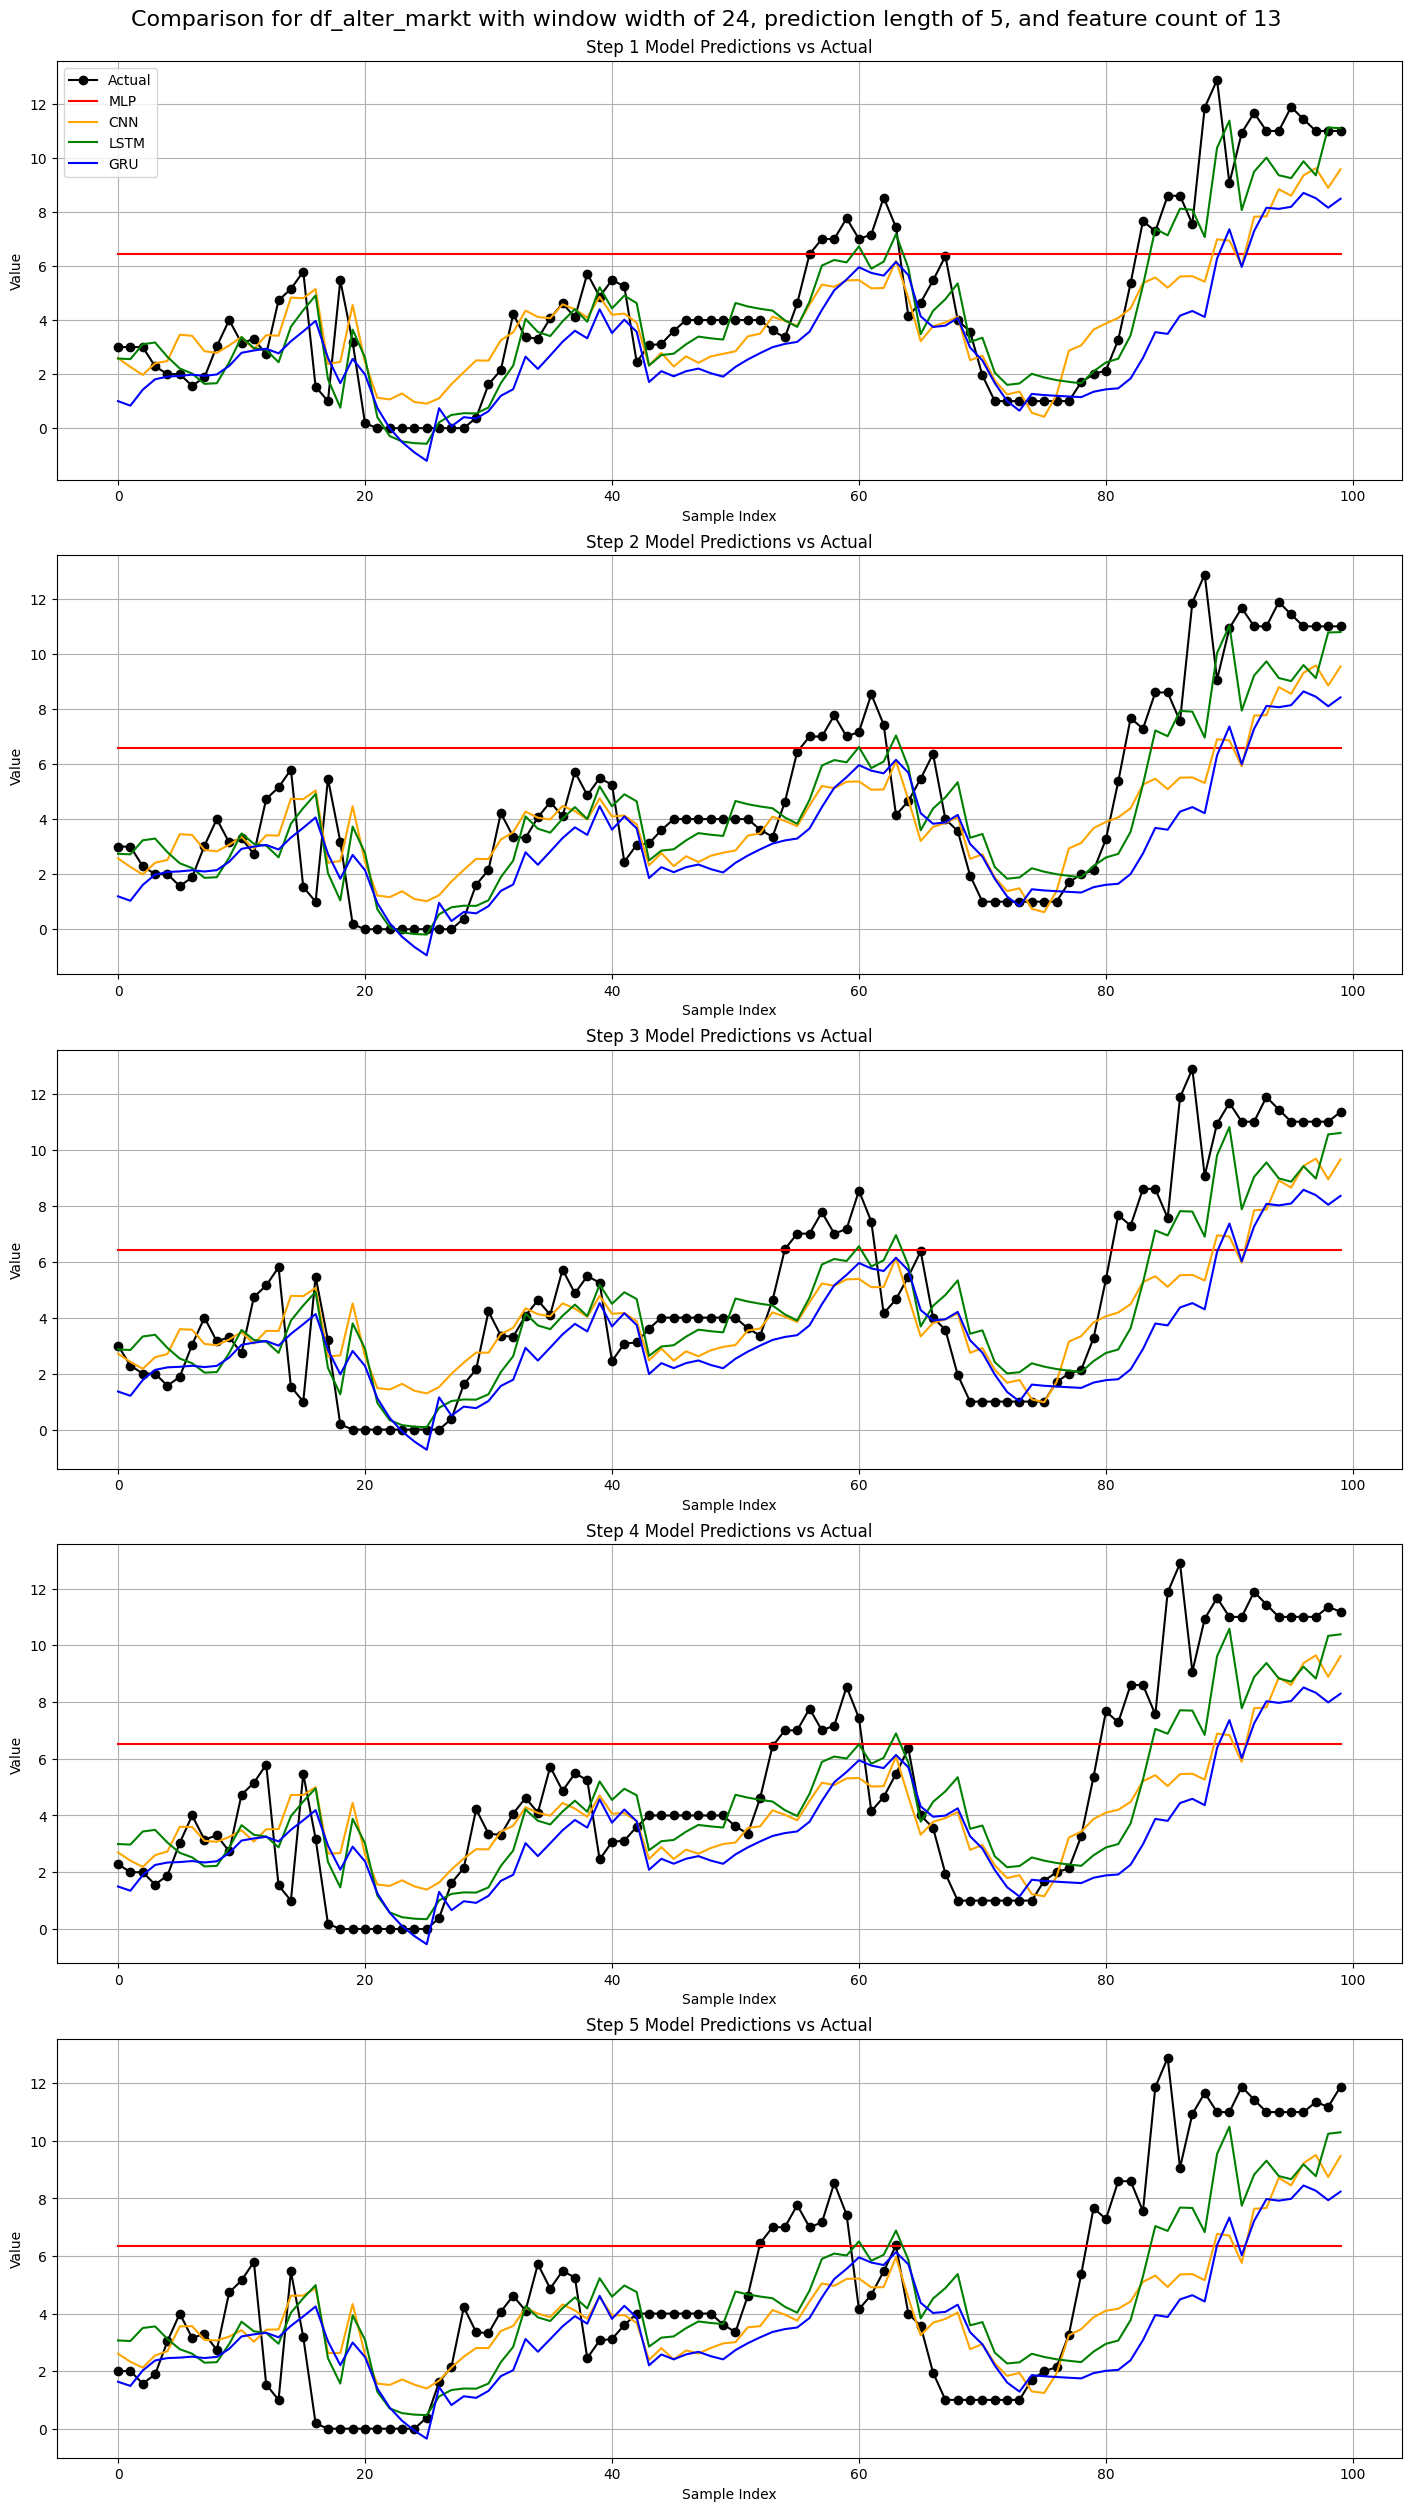

In [117]:
# Number of prediction steps
num_prediction_steps = 5

# Create subplots, one for each prediction step
fig, axs = plt.subplots(num_prediction_steps, 1, figsize=(14, 5 * num_prediction_steps), constrained_layout=True)

# Number of rows you want to plot
num_rows_to_plot = 100

# Define colors and markers for each model
colors = {'MLP': 'red', 'CNN': 'orange', 'LSTM': 'green', 'GRU': 'blue'}
markers = {'MLP': '*', 'CNN': '*', 'LSTM': '*', 'GRU': '^'}

model_names = ['MLP', 'CNN', 'LSTM', 'GRU']

# Prepare arrays for all values
x_values = np.arange(num_rows_to_plot)

for step in range(num_prediction_steps):
    # Plot actual values with a line for this step
    actual_values = [predictions_df_alter_markt['actual'][i][step] for i in range(num_rows_to_plot)]
    axs[step].plot(x_values, actual_values, label='Actual', marker='o', color='black')

    # Plot predictions for each model with lines and markers for this step
    for model_name in model_names:
        model_values = [predictions_df_alter_markt[model_name][i][step] for i in range(num_rows_to_plot)]
        axs[step].plot(x_values, model_values, label=model_name, color=colors[model_name])

    # Set titles and labels
    axs[step].set_title(f'Step {step + 1} Model Predictions vs Actual')
    axs[step].set_xlabel('Sample Index')
    axs[step].set_ylabel('Value')
    axs[step].grid(True)

# Set the legend on the first subplot
axs[0].legend(loc='best') # , frameon=False

# Set the overall title for the plot
plt.suptitle(f'Comparison for {datasetname} with window width of {sliding_window_width}, prediction length of {prediction_length_steps}, and feature count of {original_feature_count}', fontsize=16)

# Save plot if needed
# file_name = f'Results/JH_{datasetname}_all_steps_comparison_{look_ahead_steps}.png'
# plt.savefig(file_name)

plt.show()